## Test on a simple case
Consider the following Poisson Equation
$$
\begin{cases}
    \Delta u = 0\qquad &u\in\Omega\\
    u = xy\qquad &u\in\partial\Omega.
\end{cases}$$
Here $\Omega = \{(x, y)|\ 0< x, y< 1\}$

The exact solution to this problem is $$u = xy.$$

In [37]:
% matplotlib inline
import torch 
import torch.nn.functional as F
#learning rate decay
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm

torch.set_default_tensor_type('torch.FloatTensor')

class DeepRitzNet(torch.nn.Module):
    def __init__(self, m):
        super(DeepRitzNet, self).__init__()
        self.linear1 = torch.nn.Linear(m,m)
        self.linear2 = torch.nn.Linear(m,m)
        self.linear3 = torch.nn.Linear(m,m)
        self.linear4 = torch.nn.Linear(m,m)
        self.linear5 = torch.nn.Linear(m,m)
        self.linear6 = torch.nn.Linear(m,m)
        
        self.linear7 = torch.nn.Linear(m,1)
        
        torch.nn.init.constant_(self.linear1.bias, 0.)
        torch.nn.init.constant_(self.linear2.bias, 0.)
        torch.nn.init.constant_(self.linear3.bias, 0.)
        torch.nn.init.constant_(self.linear4.bias, 0.)
        torch.nn.init.constant_(self.linear5.bias, 0.)
        torch.nn.init.constant_(self.linear6.bias, 0.)
        torch.nn.init.constant_(self.linear7.bias, 0.)
        
        torch.nn.init.normal_(self.linear1.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear2.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear3.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear4.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear5.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear6.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear7.weight, mean=0, std=0.1)
        
        
        '''
        torch.nn.init.xavier_uniform_(self.linear1.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear2.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear3.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear4.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear5.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear6.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear7.weight, gain=torch.nn.init.calculate_gain('relu'))
        '''
    def forward(self, x):
        y = x
        y = y + F.relu(self.linear2(F.relu(self.linear1(y))))
        #y = y + F.relu(self.linear4(F.relu(self.linear3(y))))
        #y = y + F.relu(self.linear6(F.relu(self.linear5(y))))
        output = F.relu(self.linear7(y))
        return output

In [3]:
def cal_loss(mod):
    points = np.arange(0, 1.1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    mmm = 0
    t = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() - U_groundtruth(re)
            mmm += abs(z[i, j])
            t += 1
    return mmm / t

In [4]:
#相对误差
#余冰的例子里面是
#print(np.linalg.norm(np.reshape(u_solve[:,0]-pu,[-1]),ord=2)/np.linalg.norm(np.reshape(pu,[-1]),ord=2))
def relative_err(mod):
    points = np.arange(0, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    w = np.zeros((xl, yl))
    t = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)
            z[i, j] = mod(re.float()).item() - U_groundtruth(re)
            w[i, j] = U_groundtruth(re)
            t += 1
    z = z ** 2
    w = w ** 2
    return np.sum(z) / np.sum(w)

In [5]:
#U_groundtruth = x * y
#take in a (m,) tensor (x, y, ...)
def U_groundtruth(t):
    return (t[0] * t[1]).item()

In [6]:
def validate(mod):
    draw_graph(mod)
    print(cal_loss(mod))

In [24]:
def draw_graph(mod):
    points = np.arange(0, 1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() - U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    
    my_x_ticks = np.arange(0, 1, 0.2)
    my_y_ticks = np.arange(0, 1, 0.2)
    ax = plt.gca()
    ax.set_xticks(np.linspace(0,99,5))  
    ax.set_xticklabels(('0', '0.25', '0.5', '0.75', '1'))  
    ax.set_yticks(np.linspace(0,99,5))  
    ax.set_yticklabels( ('1', '0.75', '0.5', '0.25', '0'))  
    
    #plt.savefig("../Adaptive/loss_1.eps")
    
    plt.savefig("loss_yubing.eps")
    plt.show()

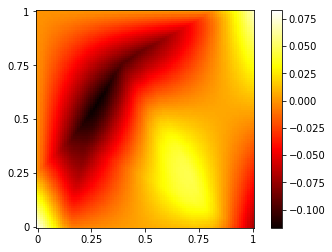

0.02921018591104461


In [35]:
validate(model)

In [29]:
relative_err(model)

0.999406945869644

In [36]:
#only save the parameters
PATH = 'test_parameters.pkl'
torch.save(model.state_dict(), PATH)

In [10]:
m = 10
PATH = 'test_parameters.pkl'
#从文件读取the_model
model = DeepRitzNet(m)
model.load_state_dict(torch.load(PATH))

In [38]:
model = DeepRitzNet(m)

In [39]:
#训练the_model
train(model, opt='Adam', iterations=50000, milestones=[10000,20000,30000,40000], gamma=0.5, beta=1, 
      beta_increase=1.01, alpha=0, alpha_increase=1, initial_lr=0.00001, print_every_iter=5)

4  epoch, loss:  0.006223101
4  epoch, regularization loss:  0.18070714
4  loss to real solution:  0.23366667958753845
9  epoch, loss:  0.0062260497
9  epoch, regularization loss:  0.16430765
9  loss to real solution:  0.23363736800095142
14  epoch, loss:  0.0062287827
14  epoch, regularization loss:  0.18952046
14  loss to real solution:  0.23360421776055734
19  epoch, loss:  0.0062315487
19  epoch, regularization loss:  0.19659549
19  loss to real solution:  0.2335664103280999
24  epoch, loss:  0.0062346756
24  epoch, regularization loss:  0.20574868
24  loss to real solution:  0.2335274643754425
29  epoch, loss:  0.0062427176
29  epoch, regularization loss:  0.2033542
29  loss to real solution:  0.23348522745784803
34  epoch, loss:  0.0062463405
34  epoch, regularization loss:  0.2299787
34  loss to real solution:  0.2334443379740023
39  epoch, loss:  0.006249845
39  epoch, regularization loss:  0.21343975
39  loss to real solution:  0.23340236812229614
44  epoch, loss:  0.006256744

339  epoch, loss:  0.007361031
339  epoch, regularization loss:  3.4177258
339  loss to real solution:  0.22958187932950974
344  epoch, loss:  0.0073696673
344  epoch, regularization loss:  5.3149056
344  loss to real solution:  0.22941387931496857
349  epoch, loss:  0.007495841
349  epoch, regularization loss:  4.832499
349  loss to real solution:  0.22923652008822384
354  epoch, loss:  0.0075071007
354  epoch, regularization loss:  5.754554
354  loss to real solution:  0.22905941641427696
359  epoch, loss:  0.007511646
359  epoch, regularization loss:  5.4099236
359  loss to real solution:  0.22887935304240714
364  epoch, loss:  0.0075261653
364  epoch, regularization loss:  3.9509685
364  loss to real solution:  0.22869893785669998
369  epoch, loss:  0.007649366
369  epoch, regularization loss:  6.501139
369  loss to real solution:  0.22852102744670136
374  epoch, loss:  0.00767612
374  epoch, regularization loss:  5.173416
374  loss to real solution:  0.228339207628357
379  epoch, 

674  epoch, loss:  0.010350213
674  epoch, regularization loss:  58.68121
674  loss to real solution:  0.21473030447036273
679  epoch, loss:  0.010365994
679  epoch, regularization loss:  53.176598
679  loss to real solution:  0.21451346887629633
684  epoch, loss:  0.0103882095
684  epoch, regularization loss:  81.44397
684  loss to real solution:  0.21430194532683441
689  epoch, loss:  0.010401512
689  epoch, regularization loss:  67.67444
689  loss to real solution:  0.21408991370242364
694  epoch, loss:  0.010419936
694  epoch, regularization loss:  74.32311
694  loss to real solution:  0.21388844979911548
699  epoch, loss:  0.010435836
699  epoch, regularization loss:  64.953766
699  loss to real solution:  0.21369481388525652
704  epoch, loss:  0.010446821
704  epoch, regularization loss:  60.889168
704  loss to real solution:  0.21350403675455445
709  epoch, loss:  0.010591005
709  epoch, regularization loss:  68.983
709  loss to real solution:  0.21331278456467365
714  epoch, lo

1009  epoch, loss:  0.012491435
1009  epoch, regularization loss:  58.98946
1009  loss to real solution:  0.2035304868181259
1014  epoch, loss:  0.012505721
1014  epoch, regularization loss:  58.38791
1014  loss to real solution:  0.20338897746364193
1019  epoch, loss:  0.012514843
1019  epoch, regularization loss:  59.259365
1019  loss to real solution:  0.20324932007873353
1024  epoch, loss:  0.01252746
1024  epoch, regularization loss:  69.71296
1024  loss to real solution:  0.20311226138013824
1029  epoch, loss:  0.012543082
1029  epoch, regularization loss:  61.339653
1029  loss to real solution:  0.20297367907244682
1034  epoch, loss:  0.012556683
1034  epoch, regularization loss:  73.74814
1034  loss to real solution:  0.2028346345247316
1039  epoch, loss:  0.012571986
1039  epoch, regularization loss:  56.712452
1039  loss to real solution:  0.20270011453450587
1044  epoch, loss:  0.012583695
1044  epoch, regularization loss:  64.554436
1044  loss to real solution:  0.202566399

1334  epoch, loss:  0.013968533
1334  epoch, regularization loss:  53.229977
1334  loss to real solution:  0.19515734615404745
1339  epoch, loss:  0.013985767
1339  epoch, regularization loss:  65.72563
1339  loss to real solution:  0.19503453414702465
1344  epoch, loss:  0.013995899
1344  epoch, regularization loss:  53.704815
1344  loss to real solution:  0.1949141956250037
1349  epoch, loss:  0.01401291
1349  epoch, regularization loss:  70.75758
1349  loss to real solution:  0.19479540083557367
1354  epoch, loss:  0.014031399
1354  epoch, regularization loss:  69.082306
1354  loss to real solution:  0.1946770319530417
1359  epoch, loss:  0.014045477
1359  epoch, regularization loss:  49.00716
1359  loss to real solution:  0.19456271632489833
1364  epoch, loss:  0.014059087
1364  epoch, regularization loss:  59.315517
1364  loss to real solution:  0.19445393110571568
1369  epoch, loss:  0.014072201
1369  epoch, regularization loss:  62.27877
1369  loss to real solution:  0.194343735

1659  epoch, loss:  0.015209717
1659  epoch, regularization loss:  49.964813
1659  loss to real solution:  0.18837363181743494
1664  epoch, loss:  0.015255462
1664  epoch, regularization loss:  54.063126
1664  loss to real solution:  0.1882844207897659
1669  epoch, loss:  0.015264263
1669  epoch, regularization loss:  41.613205
1669  loss to real solution:  0.18819144317033615
1674  epoch, loss:  0.015286683
1674  epoch, regularization loss:  61.766052
1674  loss to real solution:  0.18810096017154285
1679  epoch, loss:  0.0152975395
1679  epoch, regularization loss:  41.299965
1679  loss to real solution:  0.18800581345565553
1684  epoch, loss:  0.015447562
1684  epoch, regularization loss:  49.962677
1684  loss to real solution:  0.18791192841246598
1689  epoch, loss:  0.015462565
1689  epoch, regularization loss:  66.46457
1689  loss to real solution:  0.18782082478338774
1694  epoch, loss:  0.015477047
1694  epoch, regularization loss:  76.56949
1694  loss to real solution:  0.1877

1984  epoch, loss:  0.016516067
1984  epoch, regularization loss:  54.65329
1984  loss to real solution:  0.18272490912755907
1989  epoch, loss:  0.016536599
1989  epoch, regularization loss:  62.850246
1989  loss to real solution:  0.18264009614375012
1994  epoch, loss:  0.016550398
1994  epoch, regularization loss:  63.16392
1994  loss to real solution:  0.18255561982150662
1999  epoch, loss:  0.01657099
1999  epoch, regularization loss:  42.769833
1999  loss to real solution:  0.18247124582929308
2004  epoch, loss:  0.016580924
2004  epoch, regularization loss:  53.666584
2004  loss to real solution:  0.182394376549839
2009  epoch, loss:  0.016595919
2009  epoch, regularization loss:  62.080856
2009  loss to real solution:  0.1823124090797645
2014  epoch, loss:  0.01661431
2014  epoch, regularization loss:  55.4486
2014  loss to real solution:  0.18222550132827572
2019  epoch, loss:  0.016634947
2019  epoch, regularization loss:  52.871017
2019  loss to real solution:  0.18213796715

2314  epoch, loss:  0.01778005
2314  epoch, regularization loss:  49.75645
2314  loss to real solution:  0.17739087594318986
2319  epoch, loss:  0.017795768
2319  epoch, regularization loss:  56.80132
2319  loss to real solution:  0.17731565366537613
2324  epoch, loss:  0.017814143
2324  epoch, regularization loss:  39.664883
2324  loss to real solution:  0.17724008478162706
2329  epoch, loss:  0.017833212
2329  epoch, regularization loss:  41.638866
2329  loss to real solution:  0.17716417041568722
2334  epoch, loss:  0.017861616
2334  epoch, regularization loss:  43.696217
2334  loss to real solution:  0.1770877856010002
2339  epoch, loss:  0.017873188
2339  epoch, regularization loss:  61.24129
2339  loss to real solution:  0.17701473950847124
2344  epoch, loss:  0.017901704
2344  epoch, regularization loss:  55.029583
2344  loss to real solution:  0.17694071093989802
2349  epoch, loss:  0.017918924
2349  epoch, regularization loss:  39.18601
2349  loss to real solution:  0.17686929

2639  epoch, loss:  0.019100253
2639  epoch, regularization loss:  45.80269
2639  loss to real solution:  0.1728267549772647
2644  epoch, loss:  0.019115739
2644  epoch, regularization loss:  43.03408
2644  loss to real solution:  0.1727611284622969
2649  epoch, loss:  0.019133722
2649  epoch, regularization loss:  60.031384
2649  loss to real solution:  0.17269378763646628
2654  epoch, loss:  0.01915358
2654  epoch, regularization loss:  49.857403
2654  loss to real solution:  0.172624817196249
2659  epoch, loss:  0.01918405
2659  epoch, regularization loss:  41.5912
2659  loss to real solution:  0.17256069097267698
2664  epoch, loss:  0.019197093
2664  epoch, regularization loss:  40.37431
2664  loss to real solution:  0.1724997189308494
2669  epoch, loss:  0.019216405
2669  epoch, regularization loss:  46.064396
2669  loss to real solution:  0.17243575954486517
2674  epoch, loss:  0.019239513
2674  epoch, regularization loss:  45.781467
2674  loss to real solution:  0.17236948532198

2969  epoch, loss:  0.020570647
2969  epoch, regularization loss:  43.905178
2969  loss to real solution:  0.1685353333915561
2974  epoch, loss:  0.020596897
2974  epoch, regularization loss:  33.86066
2974  loss to real solution:  0.16847537561389045
2979  epoch, loss:  0.020619802
2979  epoch, regularization loss:  49.5515
2979  loss to real solution:  0.16841519074745417
2984  epoch, loss:  0.020640926
2984  epoch, regularization loss:  52.581635
2984  loss to real solution:  0.16835503294325077
2989  epoch, loss:  0.02066706
2989  epoch, regularization loss:  41.01612
2989  loss to real solution:  0.168293083582289
2994  epoch, loss:  0.020693507
2994  epoch, regularization loss:  53.601936
2994  loss to real solution:  0.16822964432072052
2999  epoch, loss:  0.020720873
2999  epoch, regularization loss:  56.923534
2999  loss to real solution:  0.16816338486045848
3004  epoch, loss:  0.020750023
3004  epoch, regularization loss:  37.768017
3004  loss to real solution:  0.1680951333

3294  epoch, loss:  0.0222839
3294  epoch, regularization loss:  59.411255
3294  loss to real solution:  0.16487055776409876
3299  epoch, loss:  0.0223134
3299  epoch, regularization loss:  44.54325
3299  loss to real solution:  0.16481360491026542
3304  epoch, loss:  0.022341816
3304  epoch, regularization loss:  39.294456
3304  loss to real solution:  0.1647567335817933
3309  epoch, loss:  0.022381082
3309  epoch, regularization loss:  40.25431
3309  loss to real solution:  0.16470135963529603
3314  epoch, loss:  0.022390002
3314  epoch, regularization loss:  33.74198
3314  loss to real solution:  0.1646496092263333
3319  epoch, loss:  0.022434583
3319  epoch, regularization loss:  49.847034
3319  loss to real solution:  0.16460190805398736
3324  epoch, loss:  0.022447977
3324  epoch, regularization loss:  41.632008
3324  loss to real solution:  0.16455228826600668
3329  epoch, loss:  0.022487752
3329  epoch, regularization loss:  37.498394
3329  loss to real solution:  0.16450051298

3619  epoch, loss:  0.02405249
3619  epoch, regularization loss:  35.565712
3619  loss to real solution:  0.16192026155792982
3624  epoch, loss:  0.024076898
3624  epoch, regularization loss:  58.99768
3624  loss to real solution:  0.16187954585906894
3629  epoch, loss:  0.024127748
3629  epoch, regularization loss:  32.917862
3629  loss to real solution:  0.1618365801156553
3634  epoch, loss:  0.024154382
3634  epoch, regularization loss:  40.156803
3634  loss to real solution:  0.16179498955853722
3639  epoch, loss:  0.024181321
3639  epoch, regularization loss:  35.264458
3639  loss to real solution:  0.16175301702061967
3644  epoch, loss:  0.024213238
3644  epoch, regularization loss:  40.10852
3644  loss to real solution:  0.1617113582383503
3649  epoch, loss:  0.024232337
3649  epoch, regularization loss:  42.783978
3649  loss to real solution:  0.1616699891666736
3654  epoch, loss:  0.02426157
3654  epoch, regularization loss:  24.547134
3654  loss to real solution:  0.161629008

3949  epoch, loss:  0.026089733
3949  epoch, regularization loss:  45.943314
3949  loss to real solution:  0.15960373910990636
3954  epoch, loss:  0.026122587
3954  epoch, regularization loss:  31.39077
3954  loss to real solution:  0.15957239156173286
3959  epoch, loss:  0.026145775
3959  epoch, regularization loss:  34.38783
3959  loss to real solution:  0.15954225347061793
3964  epoch, loss:  0.026176862
3964  epoch, regularization loss:  49.5193
3964  loss to real solution:  0.1595128268791625
3969  epoch, loss:  0.026203826
3969  epoch, regularization loss:  29.646404
3969  loss to real solution:  0.15948354160243822
3974  epoch, loss:  0.026240679
3974  epoch, regularization loss:  41.70029
3974  loss to real solution:  0.15945492361449018
3979  epoch, loss:  0.02626409
3979  epoch, regularization loss:  41.752094
3979  loss to real solution:  0.1594260174553257
3984  epoch, loss:  0.026292939
3984  epoch, regularization loss:  36.076336
3984  loss to real solution:  0.1593992044

4274  epoch, loss:  0.028191634
4274  epoch, regularization loss:  39.892735
4274  loss to real solution:  0.15788829127619097
4279  epoch, loss:  0.028227443
4279  epoch, regularization loss:  38.200527
4279  loss to real solution:  0.1578632503674051
4284  epoch, loss:  0.02825361
4284  epoch, regularization loss:  33.82436
4284  loss to real solution:  0.15783826229000888
4289  epoch, loss:  0.028298274
4289  epoch, regularization loss:  44.402493
4289  loss to real solution:  0.15781341170969096
4294  epoch, loss:  0.028317653
4294  epoch, regularization loss:  39.25683
4294  loss to real solution:  0.15778867547423395
4299  epoch, loss:  0.028352732
4299  epoch, regularization loss:  36.5617
4299  loss to real solution:  0.15776361178268095
4304  epoch, loss:  0.028369248
4304  epoch, regularization loss:  37.73703
4304  loss to real solution:  0.1577390360733695
4309  epoch, loss:  0.028395882
4309  epoch, regularization loss:  33.982822
4309  loss to real solution:  0.1577143529

4599  epoch, loss:  0.03039996
4599  epoch, regularization loss:  41.041855
4599  loss to real solution:  0.1563521573366213
4604  epoch, loss:  0.030434262
4604  epoch, regularization loss:  32.109737
4604  loss to real solution:  0.1563301119922607
4609  epoch, loss:  0.030469878
4609  epoch, regularization loss:  37.30578
4609  loss to real solution:  0.15630779510194612
4614  epoch, loss:  0.030501077
4614  epoch, regularization loss:  37.71362
4614  loss to real solution:  0.1562857911360166
4619  epoch, loss:  0.030542336
4619  epoch, regularization loss:  27.69453
4619  loss to real solution:  0.15626397885320606
4624  epoch, loss:  0.03057589
4624  epoch, regularization loss:  33.0508
4624  loss to real solution:  0.15624188714283563
4629  epoch, loss:  0.030611027
4629  epoch, regularization loss:  40.235996
4629  loss to real solution:  0.15622000158572005
4634  epoch, loss:  0.030637026
4634  epoch, regularization loss:  37.622448
4634  loss to real solution:  0.156198575624

4924  epoch, loss:  0.032729536
4924  epoch, regularization loss:  29.051037
4924  loss to real solution:  0.15502659492748835
4929  epoch, loss:  0.03275708
4929  epoch, regularization loss:  39.160503
4929  loss to real solution:  0.15501224652548473
4934  epoch, loss:  0.032794133
4934  epoch, regularization loss:  35.435013
4934  loss to real solution:  0.1549969890294982
4939  epoch, loss:  0.032818448
4939  epoch, regularization loss:  38.705746
4939  loss to real solution:  0.154983437223868
4944  epoch, loss:  0.032861866
4944  epoch, regularization loss:  40.982613
4944  loss to real solution:  0.1549702831930366
4949  epoch, loss:  0.032896187
4949  epoch, regularization loss:  31.966324
4949  loss to real solution:  0.15495659044212554
4954  epoch, loss:  0.03292767
4954  epoch, regularization loss:  38.43053
4954  loss to real solution:  0.15494107026699167
4959  epoch, loss:  0.03298679
4959  epoch, regularization loss:  33.024353
4959  loss to real solution:  0.1549262165

5254  epoch, loss:  0.035084113
5254  epoch, regularization loss:  34.174904
5254  loss to real solution:  0.1539498975503544
5259  epoch, loss:  0.035121694
5259  epoch, regularization loss:  27.741823
5259  loss to real solution:  0.15393429129330588
5264  epoch, loss:  0.03515649
5264  epoch, regularization loss:  32.491493
5264  loss to real solution:  0.15391884950320592
5269  epoch, loss:  0.03518169
5269  epoch, regularization loss:  31.338406
5269  loss to real solution:  0.15390451821906517
5274  epoch, loss:  0.0352568
5274  epoch, regularization loss:  28.418459
5274  loss to real solution:  0.15388909059122582
5279  epoch, loss:  0.03528686
5279  epoch, regularization loss:  30.043194
5279  loss to real solution:  0.15387340810427005
5284  epoch, loss:  0.035344053
5284  epoch, regularization loss:  41.55923
5284  loss to real solution:  0.15385430900272268
5289  epoch, loss:  0.035369135
5289  epoch, regularization loss:  31.875345
5289  loss to real solution:  0.153835113

5584  epoch, loss:  0.037604038
5584  epoch, regularization loss:  37.705837
5584  loss to real solution:  0.15286107260087314
5589  epoch, loss:  0.037657842
5589  epoch, regularization loss:  41.17067
5589  loss to real solution:  0.1528469495635388
5594  epoch, loss:  0.03772864
5594  epoch, regularization loss:  25.02424
5594  loss to real solution:  0.15283073506818337
5599  epoch, loss:  0.037808187
5599  epoch, regularization loss:  40.89272
5599  loss to real solution:  0.15281102138609934
5604  epoch, loss:  0.037862543
5604  epoch, regularization loss:  35.659897
5604  loss to real solution:  0.15279044596124294
5609  epoch, loss:  0.037922844
5609  epoch, regularization loss:  27.893452
5609  loss to real solution:  0.15277039965075903
5614  epoch, loss:  0.037969366
5614  epoch, regularization loss:  32.313385
5614  loss to real solution:  0.1527513687743629
5619  epoch, loss:  0.037983585
5619  epoch, regularization loss:  31.074781
5619  loss to real solution:  0.15273717

5914  epoch, loss:  0.040187858
5914  epoch, regularization loss:  32.63276
5914  loss to real solution:  0.1517077190201145
5919  epoch, loss:  0.040234543
5919  epoch, regularization loss:  35.042255
5919  loss to real solution:  0.15169148753004633
5924  epoch, loss:  0.040270142
5924  epoch, regularization loss:  34.410694
5924  loss to real solution:  0.15167588749207747
5929  epoch, loss:  0.040304758
5929  epoch, regularization loss:  30.220665
5929  loss to real solution:  0.15165720617721895
5934  epoch, loss:  0.040340487
5934  epoch, regularization loss:  30.583586
5934  loss to real solution:  0.1516428649179207
5939  epoch, loss:  0.04037819
5939  epoch, regularization loss:  31.875969
5939  loss to real solution:  0.15162842667792462
5944  epoch, loss:  0.040423363
5944  epoch, regularization loss:  28.634026
5944  loss to real solution:  0.15161195412155032
5949  epoch, loss:  0.040459022
5949  epoch, regularization loss:  27.26249
5949  loss to real solution:  0.1515949

6244  epoch, loss:  0.042799205
6244  epoch, regularization loss:  34.073933
6244  loss to real solution:  0.15042786037380054
6249  epoch, loss:  0.04284162
6249  epoch, regularization loss:  37.74865
6249  loss to real solution:  0.15040664998706718
6254  epoch, loss:  0.042886667
6254  epoch, regularization loss:  25.229492
6254  loss to real solution:  0.1503868917862247
6259  epoch, loss:  0.04291527
6259  epoch, regularization loss:  33.309258
6259  loss to real solution:  0.15036772926237968
6264  epoch, loss:  0.042960607
6264  epoch, regularization loss:  28.532137
6264  loss to real solution:  0.15034809759825724
6269  epoch, loss:  0.042982794
6269  epoch, regularization loss:  34.21071
6269  loss to real solution:  0.15032438215391705
6274  epoch, loss:  0.0430253
6274  epoch, regularization loss:  26.728247
6274  loss to real solution:  0.1503004058776809
6279  epoch, loss:  0.043064002
6279  epoch, regularization loss:  31.485949
6279  loss to real solution:  0.1502729331

6569  epoch, loss:  0.045368504
6569  epoch, regularization loss:  28.382875
6569  loss to real solution:  0.14922341955102186
6574  epoch, loss:  0.045416374
6574  epoch, regularization loss:  32.605545
6574  loss to real solution:  0.1492106063380715
6579  epoch, loss:  0.045478076
6579  epoch, regularization loss:  31.588995
6579  loss to real solution:  0.14919377375240175
6584  epoch, loss:  0.045501493
6584  epoch, regularization loss:  33.19826
6584  loss to real solution:  0.1491729882950626
6589  epoch, loss:  0.04554291
6589  epoch, regularization loss:  26.427137
6589  loss to real solution:  0.14914674328624716
6594  epoch, loss:  0.04558443
6594  epoch, regularization loss:  29.617464
6594  loss to real solution:  0.14912647037959303
6599  epoch, loss:  0.045609966
6599  epoch, regularization loss:  29.452606
6599  loss to real solution:  0.14909700474955825
6604  epoch, loss:  0.0456543
6604  epoch, regularization loss:  27.556135
6604  loss to real solution:  0.149069605

6894  epoch, loss:  0.048167974
6894  epoch, regularization loss:  26.996243
6894  loss to real solution:  0.14785346591521892
6899  epoch, loss:  0.048209332
6899  epoch, regularization loss:  29.35089
6899  loss to real solution:  0.1478251806172458
6904  epoch, loss:  0.048236553
6904  epoch, regularization loss:  29.464691
6904  loss to real solution:  0.1477998304170026
6909  epoch, loss:  0.048286818
6909  epoch, regularization loss:  29.319534
6909  loss to real solution:  0.14777722430869575
6914  epoch, loss:  0.048339453
6914  epoch, regularization loss:  32.14431
6914  loss to real solution:  0.14774774346962455
6919  epoch, loss:  0.048353747
6919  epoch, regularization loss:  32.950104
6919  loss to real solution:  0.14772006123765447
6924  epoch, loss:  0.048395503
6924  epoch, regularization loss:  33.98996
6924  loss to real solution:  0.1476878911700131
6929  epoch, loss:  0.048446182
6929  epoch, regularization loss:  23.994997
6929  loss to real solution:  0.14765605

7219  epoch, loss:  0.050772153
7219  epoch, regularization loss:  27.867777
7219  loss to real solution:  0.1458264308478222
7224  epoch, loss:  0.050813895
7224  epoch, regularization loss:  28.626348
7224  loss to real solution:  0.14580155939356362
7229  epoch, loss:  0.050873768
7229  epoch, regularization loss:  28.628042
7229  loss to real solution:  0.1457895994260292
7234  epoch, loss:  0.050906695
7234  epoch, regularization loss:  25.840824
7234  loss to real solution:  0.14577175011319568
7239  epoch, loss:  0.05096893
7239  epoch, regularization loss:  28.967955
7239  loss to real solution:  0.14574656573455202
7244  epoch, loss:  0.051013242
7244  epoch, regularization loss:  31.525076
7244  loss to real solution:  0.14572068500371024
7249  epoch, loss:  0.051043782
7249  epoch, regularization loss:  28.000454
7249  loss to real solution:  0.1456897918178031
7254  epoch, loss:  0.051102743
7254  epoch, regularization loss:  28.731892
7254  loss to real solution:  0.145656

7549  epoch, loss:  0.053920366
7549  epoch, regularization loss:  31.86191
7549  loss to real solution:  0.14367166641329934
7554  epoch, loss:  0.053976398
7554  epoch, regularization loss:  23.473434
7554  loss to real solution:  0.1436392831112728
7559  epoch, loss:  0.05409117
7559  epoch, regularization loss:  26.454832
7559  loss to real solution:  0.1436056003910451
7564  epoch, loss:  0.05415344
7564  epoch, regularization loss:  29.016365
7564  loss to real solution:  0.1435843687609208
7569  epoch, loss:  0.05422698
7569  epoch, regularization loss:  37.15609
7569  loss to real solution:  0.14356896828767685
7574  epoch, loss:  0.054286342
7574  epoch, regularization loss:  33.009907
7574  loss to real solution:  0.14355222664835043
7579  epoch, loss:  0.054347526
7579  epoch, regularization loss:  30.960596
7579  loss to real solution:  0.14353383405888379
7584  epoch, loss:  0.054411076
7584  epoch, regularization loss:  27.320158
7584  loss to real solution:  0.1435125824

7879  epoch, loss:  0.057383094
7879  epoch, regularization loss:  26.510448
7879  loss to real solution:  0.1414200891221851
7884  epoch, loss:  0.057441354
7884  epoch, regularization loss:  27.00168
7884  loss to real solution:  0.1413899372382598
7889  epoch, loss:  0.05750597
7889  epoch, regularization loss:  20.632519
7889  loss to real solution:  0.1413639365592279
7894  epoch, loss:  0.057545412
7894  epoch, regularization loss:  23.469591
7894  loss to real solution:  0.1413245331477528
7899  epoch, loss:  0.057598244
7899  epoch, regularization loss:  27.500883
7899  loss to real solution:  0.14128179741792446
7904  epoch, loss:  0.057645798
7904  epoch, regularization loss:  25.511845
7904  loss to real solution:  0.14124569362845307
7909  epoch, loss:  0.057704333
7909  epoch, regularization loss:  26.217428
7909  loss to real solution:  0.14121482217853723
7914  epoch, loss:  0.057757184
7914  epoch, regularization loss:  23.381079
7914  loss to real solution:  0.14118063

8209  epoch, loss:  0.060796924
8209  epoch, regularization loss:  26.542126
8209  loss to real solution:  0.13876348892273002
8214  epoch, loss:  0.06085169
8214  epoch, regularization loss:  21.882776
8214  loss to real solution:  0.1387366936177262
8219  epoch, loss:  0.060911484
8219  epoch, regularization loss:  27.5477
8219  loss to real solution:  0.13871135536304194
8224  epoch, loss:  0.06098332
8224  epoch, regularization loss:  30.80571
8224  loss to real solution:  0.13868467267879775
8229  epoch, loss:  0.06106164
8229  epoch, regularization loss:  31.031004
8229  loss to real solution:  0.13865593886818772
8234  epoch, loss:  0.06111561
8234  epoch, regularization loss:  25.01064
8234  loss to real solution:  0.13862405259993454
8239  epoch, loss:  0.061135612
8239  epoch, regularization loss:  32.685432
8239  loss to real solution:  0.1385849025697748
8244  epoch, loss:  0.061213754
8244  epoch, regularization loss:  30.12371
8244  loss to real solution:  0.1385459489024

8539  epoch, loss:  0.064399205
8539  epoch, regularization loss:  34.694103
8539  loss to real solution:  0.13621071410326926
8544  epoch, loss:  0.06449508
8544  epoch, regularization loss:  30.888706
8544  loss to real solution:  0.1361761171475423
8549  epoch, loss:  0.06451142
8549  epoch, regularization loss:  26.064041
8549  loss to real solution:  0.13614393230188984
8554  epoch, loss:  0.06461081
8554  epoch, regularization loss:  27.192526
8554  loss to real solution:  0.1361047796240031
8559  epoch, loss:  0.06464026
8559  epoch, regularization loss:  29.241196
8559  loss to real solution:  0.13606887219735422
8564  epoch, loss:  0.06473901
8564  epoch, regularization loss:  20.44826
8564  loss to real solution:  0.13604027160435675
8569  epoch, loss:  0.06472843
8569  epoch, regularization loss:  25.321806
8569  loss to real solution:  0.1359915241180373
8574  epoch, loss:  0.064787365
8574  epoch, regularization loss:  27.924864
8574  loss to real solution:  0.135948079382

8869  epoch, loss:  0.06840993
8869  epoch, regularization loss:  24.994753
8869  loss to real solution:  0.13361545616560735
8874  epoch, loss:  0.068468936
8874  epoch, regularization loss:  25.484034
8874  loss to real solution:  0.13358321451697472
8879  epoch, loss:  0.068574525
8879  epoch, regularization loss:  22.158619
8879  loss to real solution:  0.13354851848699834
8884  epoch, loss:  0.06860587
8884  epoch, regularization loss:  27.062449
8884  loss to real solution:  0.13351421259651505
8889  epoch, loss:  0.06867462
8889  epoch, regularization loss:  26.147833
8889  loss to real solution:  0.13346809608877203
8894  epoch, loss:  0.06875456
8894  epoch, regularization loss:  26.684319
8894  loss to real solution:  0.1334329996916874
8899  epoch, loss:  0.06886373
8899  epoch, regularization loss:  24.304964
8899  loss to real solution:  0.1334026104359588
8904  epoch, loss:  0.0689244
8904  epoch, regularization loss:  21.7373
8904  loss to real solution:  0.1333697685845

9199  epoch, loss:  0.072355255
9199  epoch, regularization loss:  23.057451
9199  loss to real solution:  0.13053522321310915
9204  epoch, loss:  0.07235031
9204  epoch, regularization loss:  24.15392
9204  loss to real solution:  0.13049629340610233
9209  epoch, loss:  0.07244062
9209  epoch, regularization loss:  23.54082
9209  loss to real solution:  0.13045038511437823
9214  epoch, loss:  0.07247646
9214  epoch, regularization loss:  24.22704
9214  loss to real solution:  0.13039287842379133
9219  epoch, loss:  0.0725461
9219  epoch, regularization loss:  28.760185
9219  loss to real solution:  0.13032763156516497
9224  epoch, loss:  0.07257053
9224  epoch, regularization loss:  24.051128
9224  loss to real solution:  0.1302714482454722
9229  epoch, loss:  0.072627515
9229  epoch, regularization loss:  26.850243
9229  loss to real solution:  0.13022451552970354
9234  epoch, loss:  0.07269988
9234  epoch, regularization loss:  28.268742
9234  loss to real solution:  0.1301898910807

9529  epoch, loss:  0.07662689
9529  epoch, regularization loss:  20.756454
9529  loss to real solution:  0.12757227582872413
9534  epoch, loss:  0.07672064
9534  epoch, regularization loss:  19.780357
9534  loss to real solution:  0.12752795000029502
9539  epoch, loss:  0.07679375
9539  epoch, regularization loss:  24.320704
9539  loss to real solution:  0.1274886535754628
9544  epoch, loss:  0.07685783
9544  epoch, regularization loss:  24.074402
9544  loss to real solution:  0.12744660594677634
9549  epoch, loss:  0.07689264
9549  epoch, regularization loss:  21.821545
9549  loss to real solution:  0.1273927494095377
9554  epoch, loss:  0.07695485
9554  epoch, regularization loss:  26.276983
9554  loss to real solution:  0.12733933652050736
9559  epoch, loss:  0.07700214
9559  epoch, regularization loss:  23.062302
9559  loss to real solution:  0.12727474523600474
9564  epoch, loss:  0.07703556
9564  epoch, regularization loss:  25.65732
9564  loss to real solution:  0.1272205307322

9859  epoch, loss:  0.08113446
9859  epoch, regularization loss:  29.076717
9859  loss to real solution:  0.12454635646040288
9864  epoch, loss:  0.08118014
9864  epoch, regularization loss:  24.62444
9864  loss to real solution:  0.12449871984949296
9869  epoch, loss:  0.08129379
9869  epoch, regularization loss:  20.691656
9869  loss to real solution:  0.12445163941518833
9874  epoch, loss:  0.08130323
9874  epoch, regularization loss:  15.317738
9874  loss to real solution:  0.12440333399151975
9879  epoch, loss:  0.08137224
9879  epoch, regularization loss:  24.384888
9879  loss to real solution:  0.12434420338223795
9884  epoch, loss:  0.08142076
9884  epoch, regularization loss:  22.595816
9884  loss to real solution:  0.12428773981911591
9889  epoch, loss:  0.08156201
9889  epoch, regularization loss:  22.774944
9889  loss to real solution:  0.12423034391743099
9894  epoch, loss:  0.08155533
9894  epoch, regularization loss:  23.796253
9894  loss to real solution:  0.12416878766

10184  epoch, loss:  0.08411711
10184  epoch, regularization loss:  23.343782
10184  loss to real solution:  0.1222310587452833
10189  epoch, loss:  0.084164135
10189  epoch, regularization loss:  22.029299
10189  loss to real solution:  0.12220893338415009
10194  epoch, loss:  0.08420913
10194  epoch, regularization loss:  22.851212
10194  loss to real solution:  0.1221900339396902
10199  epoch, loss:  0.08425757
10199  epoch, regularization loss:  22.116304
10199  loss to real solution:  0.1221714093277524
10204  epoch, loss:  0.084303856
10204  epoch, regularization loss:  21.73209
10204  loss to real solution:  0.12215497766490571
10209  epoch, loss:  0.084343456
10209  epoch, regularization loss:  19.120285
10209  loss to real solution:  0.1221314338379163
10214  epoch, loss:  0.08436931
10214  epoch, regularization loss:  19.518604
10214  loss to real solution:  0.12210924297632764
10219  epoch, loss:  0.084404014
10219  epoch, regularization loss:  23.224651
10219  loss to real 

10504  epoch, loss:  0.08639309
10504  epoch, regularization loss:  23.31762
10504  loss to real solution:  0.12072367441678841
10509  epoch, loss:  0.086469345
10509  epoch, regularization loss:  20.8005
10509  loss to real solution:  0.12069559476407604
10514  epoch, loss:  0.08645852
10514  epoch, regularization loss:  26.313532
10514  loss to real solution:  0.12067075819208115
10519  epoch, loss:  0.08650262
10519  epoch, regularization loss:  20.01245
10519  loss to real solution:  0.12064779454826821
10524  epoch, loss:  0.08652762
10524  epoch, regularization loss:  24.129086
10524  loss to real solution:  0.12062325138906561
10529  epoch, loss:  0.08657204
10529  epoch, regularization loss:  23.890911
10529  loss to real solution:  0.12059637063329137
10534  epoch, loss:  0.086598895
10534  epoch, regularization loss:  22.680782
10534  loss to real solution:  0.12057067216458651
10539  epoch, loss:  0.08662794
10539  epoch, regularization loss:  23.44909
10539  loss to real so

10824  epoch, loss:  0.088664025
10824  epoch, regularization loss:  25.799057
10824  loss to real solution:  0.1191791267723831
10829  epoch, loss:  0.08853549
10829  epoch, regularization loss:  24.185875
10829  loss to real solution:  0.1191489637587682
10834  epoch, loss:  0.08857999
10834  epoch, regularization loss:  20.78811
10834  loss to real solution:  0.11912955425741266
10839  epoch, loss:  0.088622496
10839  epoch, regularization loss:  17.985733
10839  loss to real solution:  0.11910540823416776
10844  epoch, loss:  0.08864739
10844  epoch, regularization loss:  22.99765
10844  loss to real solution:  0.11907320695567483
10849  epoch, loss:  0.088660486
10849  epoch, regularization loss:  20.39456
10849  loss to real solution:  0.11904642680582929
10854  epoch, loss:  0.088703655
10854  epoch, regularization loss:  22.028181
10854  loss to real solution:  0.1190263834432507
10859  epoch, loss:  0.08875186
10859  epoch, regularization loss:  17.31901
10859  loss to real so

11144  epoch, loss:  0.09102337
11144  epoch, regularization loss:  21.668764
11144  loss to real solution:  0.11774064588583703
11149  epoch, loss:  0.091015026
11149  epoch, regularization loss:  20.746544
11149  loss to real solution:  0.11771841052088368
11154  epoch, loss:  0.09109143
11154  epoch, regularization loss:  19.113222
11154  loss to real solution:  0.11769870647529439
11159  epoch, loss:  0.09109961
11159  epoch, regularization loss:  19.624834
11159  loss to real solution:  0.1176726724379812
11164  epoch, loss:  0.0911269
11164  epoch, regularization loss:  21.977797
11164  loss to real solution:  0.11764633124894353
11169  epoch, loss:  0.09115464
11169  epoch, regularization loss:  23.91784
11169  loss to real solution:  0.11761588522102227
11174  epoch, loss:  0.09118576
11174  epoch, regularization loss:  24.57284
11174  loss to real solution:  0.11758367060383494
11179  epoch, loss:  0.09120934
11179  epoch, regularization loss:  20.494595
11179  loss to real so

11464  epoch, loss:  0.0933496
11464  epoch, regularization loss:  26.111586
11464  loss to real solution:  0.11615329910839398
11469  epoch, loss:  0.09341234
11469  epoch, regularization loss:  21.891691
11469  loss to real solution:  0.11613728490127025
11474  epoch, loss:  0.09343216
11474  epoch, regularization loss:  23.114515
11474  loss to real solution:  0.11611874741032602
11479  epoch, loss:  0.09349267
11479  epoch, regularization loss:  20.430454
11479  loss to real solution:  0.11609921796078036
11484  epoch, loss:  0.09353383
11484  epoch, regularization loss:  21.272177
11484  loss to real solution:  0.11608523874736035
11489  epoch, loss:  0.09358539
11489  epoch, regularization loss:  17.9257
11489  loss to real solution:  0.11607125100579642
11494  epoch, loss:  0.09362695
11494  epoch, regularization loss:  26.658363
11494  loss to real solution:  0.11604834458059521
11499  epoch, loss:  0.093652345
11499  epoch, regularization loss:  16.665802
11499  loss to real s

11784  epoch, loss:  0.09485237
11784  epoch, regularization loss:  21.420908
11784  loss to real solution:  0.11455052449929817
11789  epoch, loss:  0.09488419
11789  epoch, regularization loss:  17.537579
11789  loss to real solution:  0.11453334362977305
11794  epoch, loss:  0.094929054
11794  epoch, regularization loss:  20.751892
11794  loss to real solution:  0.11451061609547498
11799  epoch, loss:  0.09497068
11799  epoch, regularization loss:  22.290043
11799  loss to real solution:  0.11448980937935109
11804  epoch, loss:  0.09503209
11804  epoch, regularization loss:  20.800465
11804  loss to real solution:  0.1144683381915093
11809  epoch, loss:  0.095053054
11809  epoch, regularization loss:  20.105171
11809  loss to real solution:  0.11445370882256962
11814  epoch, loss:  0.09504452
11814  epoch, regularization loss:  23.107147
11814  loss to real solution:  0.1144326715078975
11819  epoch, loss:  0.09509796
11819  epoch, regularization loss:  19.443325
11819  loss to real

12104  epoch, loss:  0.097182676
12104  epoch, regularization loss:  21.799631
12104  loss to real solution:  0.11301209139552988
12109  epoch, loss:  0.09725581
12109  epoch, regularization loss:  18.486961
12109  loss to real solution:  0.11299097875918243
12114  epoch, loss:  0.097279035
12114  epoch, regularization loss:  22.681408
12114  loss to real solution:  0.1129650209979578
12119  epoch, loss:  0.097319566
12119  epoch, regularization loss:  18.029524
12119  loss to real solution:  0.11294652388485014
12124  epoch, loss:  0.09737094
12124  epoch, regularization loss:  20.80352
12124  loss to real solution:  0.11292788622669943
12129  epoch, loss:  0.09741805
12129  epoch, regularization loss:  21.137648
12129  loss to real solution:  0.11291282429305981
12134  epoch, loss:  0.09745969
12134  epoch, regularization loss:  22.599356
12134  loss to real solution:  0.11289200483090134
12139  epoch, loss:  0.09752169
12139  epoch, regularization loss:  21.346893
12139  loss to rea

12424  epoch, loss:  0.09949544
12424  epoch, regularization loss:  18.955696
12424  loss to real solution:  0.11145893860762285
12429  epoch, loss:  0.09952899
12429  epoch, regularization loss:  20.278904
12429  loss to real solution:  0.11143220630928513
12434  epoch, loss:  0.09957352
12434  epoch, regularization loss:  24.82184
12434  loss to real solution:  0.11140796544507524
12439  epoch, loss:  0.09960492
12439  epoch, regularization loss:  22.175005
12439  loss to real solution:  0.11138582932370268
12444  epoch, loss:  0.099634126
12444  epoch, regularization loss:  20.801697
12444  loss to real solution:  0.1113583372123848
12449  epoch, loss:  0.09970386
12449  epoch, regularization loss:  22.857758
12449  loss to real solution:  0.1113280762405682
12454  epoch, loss:  0.09973173
12454  epoch, regularization loss:  21.864897
12454  loss to real solution:  0.11130139818984623
12459  epoch, loss:  0.09974994
12459  epoch, regularization loss:  18.371462
12459  loss to real s

12744  epoch, loss:  0.10091423
12744  epoch, regularization loss:  20.832203
12744  loss to real solution:  0.10985751109736523
12749  epoch, loss:  0.10095202
12749  epoch, regularization loss:  17.775293
12749  loss to real solution:  0.10983799905816391
12754  epoch, loss:  0.10101261
12754  epoch, regularization loss:  20.422989
12754  loss to real solution:  0.10982544391392929
12759  epoch, loss:  0.10104054
12759  epoch, regularization loss:  17.81938
12759  loss to real solution:  0.10981159330769025
12764  epoch, loss:  0.10110253
12764  epoch, regularization loss:  19.12589
12764  loss to real solution:  0.1097940853900038
12769  epoch, loss:  0.10115285
12769  epoch, regularization loss:  18.84828
12769  loss to real solution:  0.1097723355750777
12774  epoch, loss:  0.10120194
12774  epoch, regularization loss:  19.825365
12774  loss to real solution:  0.10975040892431565
12779  epoch, loss:  0.101234764
12779  epoch, regularization loss:  20.194643
12779  loss to real sol

13064  epoch, loss:  0.10321468
13064  epoch, regularization loss:  18.830038
13064  loss to real solution:  0.10823605050910116
13069  epoch, loss:  0.103215754
13069  epoch, regularization loss:  21.744558
13069  loss to real solution:  0.10820646573904877
13074  epoch, loss:  0.10328024
13074  epoch, regularization loss:  18.367844
13074  loss to real solution:  0.10818023619326685
13079  epoch, loss:  0.10330894
13079  epoch, regularization loss:  17.33027
13079  loss to real solution:  0.10814730866789085
13084  epoch, loss:  0.10332261
13084  epoch, regularization loss:  19.507257
13084  loss to real solution:  0.10811703423422975
13089  epoch, loss:  0.103351384
13089  epoch, regularization loss:  14.821829
13089  loss to real solution:  0.10808723963951036
13094  epoch, loss:  0.1034067
13094  epoch, regularization loss:  18.178787
13094  loss to real solution:  0.10805461369331716
13099  epoch, loss:  0.103422716
13099  epoch, regularization loss:  18.758707
13099  loss to rea

13384  epoch, loss:  0.10596615
13384  epoch, regularization loss:  19.093264
13384  loss to real solution:  0.10676198121622088
13389  epoch, loss:  0.106041536
13389  epoch, regularization loss:  15.939618
13389  loss to real solution:  0.10674697357637829
13394  epoch, loss:  0.10604744
13394  epoch, regularization loss:  18.36609
13394  loss to real solution:  0.10673427778704113
13399  epoch, loss:  0.106099136
13399  epoch, regularization loss:  19.56442
13399  loss to real solution:  0.10671887665186545
13404  epoch, loss:  0.10619146
13404  epoch, regularization loss:  19.971508
13404  loss to real solution:  0.10670233853346066
13409  epoch, loss:  0.10626954
13409  epoch, regularization loss:  18.152678
13409  loss to real solution:  0.10667782886338634
13414  epoch, loss:  0.106276534
13414  epoch, regularization loss:  17.106865
13414  loss to real solution:  0.10664767531693481
13419  epoch, loss:  0.106323764
13419  epoch, regularization loss:  18.20484
13419  loss to rea

13704  epoch, loss:  0.108517714
13704  epoch, regularization loss:  23.101585
13704  loss to real solution:  0.10525939903291302
13709  epoch, loss:  0.10859756
13709  epoch, regularization loss:  18.948067
13709  loss to real solution:  0.10524456711285869
13714  epoch, loss:  0.10866003
13714  epoch, regularization loss:  17.300425
13714  loss to real solution:  0.10522411319096232
13719  epoch, loss:  0.10870563
13719  epoch, regularization loss:  15.895853
13719  loss to real solution:  0.10519804762722545
13724  epoch, loss:  0.108763896
13724  epoch, regularization loss:  16.357628
13724  loss to real solution:  0.1051648015664383
13729  epoch, loss:  0.10881977
13729  epoch, regularization loss:  21.83692
13729  loss to real solution:  0.10513743396756083
13734  epoch, loss:  0.108838364
13734  epoch, regularization loss:  22.41208
13734  loss to real solution:  0.10511553788111234
13739  epoch, loss:  0.10886151
13739  epoch, regularization loss:  20.570591
13739  loss to real

14024  epoch, loss:  0.11118503
14024  epoch, regularization loss:  15.492095
14024  loss to real solution:  0.10355225782995386
14029  epoch, loss:  0.11121794
14029  epoch, regularization loss:  16.392584
14029  loss to real solution:  0.10353408390887024
14034  epoch, loss:  0.111123174
14034  epoch, regularization loss:  16.584383
14034  loss to real solution:  0.10350413631555466
14039  epoch, loss:  0.11101601
14039  epoch, regularization loss:  18.114746
14039  loss to real solution:  0.10347291433429427
14044  epoch, loss:  0.11105734
14044  epoch, regularization loss:  19.330475
14044  loss to real solution:  0.10344075128620818
14049  epoch, loss:  0.11109325
14049  epoch, regularization loss:  20.749556
14049  loss to real solution:  0.10341425418915338
14054  epoch, loss:  0.11113524
14054  epoch, regularization loss:  18.543749
14054  loss to real solution:  0.10339656058421809
14059  epoch, loss:  0.11117098
14059  epoch, regularization loss:  20.267174
14059  loss to rea

14344  epoch, loss:  0.11233356
14344  epoch, regularization loss:  14.234752
14344  loss to real solution:  0.10179309431032459
14349  epoch, loss:  0.112380035
14349  epoch, regularization loss:  22.209166
14349  loss to real solution:  0.10177202520753484
14354  epoch, loss:  0.112431146
14354  epoch, regularization loss:  14.021589
14354  loss to real solution:  0.10174943513183066
14359  epoch, loss:  0.112453535
14359  epoch, regularization loss:  16.573477
14359  loss to real solution:  0.10172158905635938
14364  epoch, loss:  0.11251337
14364  epoch, regularization loss:  14.990758
14364  loss to real solution:  0.1016946061475834
14369  epoch, loss:  0.11252066
14369  epoch, regularization loss:  19.01767
14369  loss to real solution:  0.10166537898230901
14374  epoch, loss:  0.1125739
14374  epoch, regularization loss:  19.074795
14374  loss to real solution:  0.10163290788196339
14379  epoch, loss:  0.11259174
14379  epoch, regularization loss:  20.195066
14379  loss to real

14664  epoch, loss:  0.114820145
14664  epoch, regularization loss:  14.266031
14664  loss to real solution:  0.10020777506461324
14669  epoch, loss:  0.11487534
14669  epoch, regularization loss:  15.300096
14669  loss to real solution:  0.10017856463235769
14674  epoch, loss:  0.114910156
14674  epoch, regularization loss:  15.093985
14674  loss to real solution:  0.10015268756523117
14679  epoch, loss:  0.11494915
14679  epoch, regularization loss:  14.504347
14679  loss to real solution:  0.10012404423915161
14684  epoch, loss:  0.114985935
14684  epoch, regularization loss:  17.086565
14684  loss to real solution:  0.10009564348796679
14689  epoch, loss:  0.11505457
14689  epoch, regularization loss:  13.992818
14689  loss to real solution:  0.10007412336335698
14694  epoch, loss:  0.115108535
14694  epoch, regularization loss:  17.0565
14694  loss to real solution:  0.10004992571713268
14699  epoch, loss:  0.11514939
14699  epoch, regularization loss:  17.31438
14699  loss to rea

14984  epoch, loss:  0.11657199
14984  epoch, regularization loss:  13.339909
14984  loss to real solution:  0.09855055113530853
14989  epoch, loss:  0.116634026
14989  epoch, regularization loss:  16.572844
14989  loss to real solution:  0.09851984615353025
14994  epoch, loss:  0.11664993
14994  epoch, regularization loss:  16.349136
14994  loss to real solution:  0.09848342077298602
14999  epoch, loss:  0.11668465
14999  epoch, regularization loss:  17.394585
14999  loss to real solution:  0.09844953286931046
15004  epoch, loss:  0.11669938
15004  epoch, regularization loss:  18.120907
15004  loss to real solution:  0.09841149465357966
15009  epoch, loss:  0.11670565
15009  epoch, regularization loss:  15.646819
15009  loss to real solution:  0.09836881257101035
15014  epoch, loss:  0.116734646
15014  epoch, regularization loss:  21.204222
15014  loss to real solution:  0.09833079601430207
15019  epoch, loss:  0.116759926
15019  epoch, regularization loss:  15.977352
15019  loss to r

15304  epoch, loss:  0.11948273
15304  epoch, regularization loss:  17.742216
15304  loss to real solution:  0.09696730922753659
15309  epoch, loss:  0.11950898
15309  epoch, regularization loss:  12.208545
15309  loss to real solution:  0.09694112239174611
15314  epoch, loss:  0.119570896
15314  epoch, regularization loss:  14.906729
15314  loss to real solution:  0.09691974690691997
15319  epoch, loss:  0.119661845
15319  epoch, regularization loss:  15.401275
15319  loss to real solution:  0.09690574004630417
15324  epoch, loss:  0.11969666
15324  epoch, regularization loss:  14.350027
15324  loss to real solution:  0.09688398330803381
15329  epoch, loss:  0.11973856
15329  epoch, regularization loss:  18.534151
15329  loss to real solution:  0.09686343369851555
15334  epoch, loss:  0.119807236
15334  epoch, regularization loss:  15.195168
15334  loss to real solution:  0.0968439461623342
15339  epoch, loss:  0.11986537
15339  epoch, regularization loss:  13.964446
15339  loss to re

15624  epoch, loss:  0.12199647
15624  epoch, regularization loss:  12.8787565
15624  loss to real solution:  0.095302255092081
15629  epoch, loss:  0.12204491
15629  epoch, regularization loss:  11.975546
15629  loss to real solution:  0.09526192497615976
15634  epoch, loss:  0.1220499
15634  epoch, regularization loss:  15.151937
15634  loss to real solution:  0.09523062702668604
15639  epoch, loss:  0.12206334
15639  epoch, regularization loss:  16.91114
15639  loss to real solution:  0.09520308581696565
15644  epoch, loss:  0.1221182
15644  epoch, regularization loss:  14.534243
15644  loss to real solution:  0.0951784325384897
15649  epoch, loss:  0.122170135
15649  epoch, regularization loss:  15.553042
15649  loss to real solution:  0.09514845786754754
15654  epoch, loss:  0.12220195
15654  epoch, regularization loss:  13.161255
15654  loss to real solution:  0.09511997839266607
15659  epoch, loss:  0.12226519
15659  epoch, regularization loss:  19.134806
15659  loss to real sol

15944  epoch, loss:  0.12328048
15944  epoch, regularization loss:  13.088241
15944  loss to real solution:  0.09373139559145065
15949  epoch, loss:  0.12331153
15949  epoch, regularization loss:  14.378929
15949  loss to real solution:  0.09371180363746039
15954  epoch, loss:  0.12334871
15954  epoch, regularization loss:  15.290051
15954  loss to real solution:  0.0936970213045605
15959  epoch, loss:  0.12341935
15959  epoch, regularization loss:  13.330924
15959  loss to real solution:  0.09367770917067106
15964  epoch, loss:  0.12347488
15964  epoch, regularization loss:  14.23342
15964  loss to real solution:  0.09365502540276134
15969  epoch, loss:  0.12349746
15969  epoch, regularization loss:  11.993705
15969  loss to real solution:  0.0936362686815618
15974  epoch, loss:  0.12357263
15974  epoch, regularization loss:  17.497583
15974  loss to real solution:  0.09361057907773938
15979  epoch, loss:  0.123615295
15979  epoch, regularization loss:  12.4574795
15979  loss to real 

16264  epoch, loss:  0.1264549
16264  epoch, regularization loss:  14.688026
16264  loss to real solution:  0.09228261121163871
16269  epoch, loss:  0.12651516
16269  epoch, regularization loss:  16.963102
16269  loss to real solution:  0.09227062884040857
16274  epoch, loss:  0.12661426
16274  epoch, regularization loss:  16.734756
16274  loss to real solution:  0.09226256798952821
16279  epoch, loss:  0.12667313
16279  epoch, regularization loss:  13.884107
16279  loss to real solution:  0.09225018110488013
16284  epoch, loss:  0.1267125
16284  epoch, regularization loss:  16.354988
16284  loss to real solution:  0.09222781994210728
16289  epoch, loss:  0.12623662
16289  epoch, regularization loss:  13.896881
16289  loss to real solution:  0.09220504928411041
16294  epoch, loss:  0.12595336
16294  epoch, regularization loss:  14.650607
16294  loss to real solution:  0.0921681500220102
16299  epoch, loss:  0.12598217
16299  epoch, regularization loss:  17.593687
16299  loss to real so

16584  epoch, loss:  0.12866476
16584  epoch, regularization loss:  17.252533
16584  loss to real solution:  0.0907321990724684
16589  epoch, loss:  0.12871253
16589  epoch, regularization loss:  15.878106
16589  loss to real solution:  0.09070168237178781
16594  epoch, loss:  0.12875399
16594  epoch, regularization loss:  14.26437
16594  loss to real solution:  0.09067061340451736
16599  epoch, loss:  0.12878166
16599  epoch, regularization loss:  14.527859
16599  loss to real solution:  0.09063566711815924
16604  epoch, loss:  0.12884846
16604  epoch, regularization loss:  16.022806
16604  loss to real solution:  0.09059833173540016
16609  epoch, loss:  0.12888004
16609  epoch, regularization loss:  14.315135
16609  loss to real solution:  0.09057528071659658
16614  epoch, loss:  0.128944
16614  epoch, regularization loss:  16.189661
16614  loss to real solution:  0.09054979349648166
16619  epoch, loss:  0.12899065
16619  epoch, regularization loss:  13.870095
16619  loss to real sol

16904  epoch, loss:  0.13098234
16904  epoch, regularization loss:  13.992469
16904  loss to real solution:  0.08889333618881785
16909  epoch, loss:  0.1310386
16909  epoch, regularization loss:  13.812151
16909  loss to real solution:  0.08886014178179763
16914  epoch, loss:  0.1310473
16914  epoch, regularization loss:  12.26049
16914  loss to real solution:  0.08882626513096177
16919  epoch, loss:  0.13107884
16919  epoch, regularization loss:  14.338265
16919  loss to real solution:  0.08879474226323784
16924  epoch, loss:  0.13115273
16924  epoch, regularization loss:  15.55009
16924  loss to real solution:  0.08876633998807062
16929  epoch, loss:  0.13118234
16929  epoch, regularization loss:  16.919018
16929  loss to real solution:  0.08873628737851366
16934  epoch, loss:  0.13119483
16934  epoch, regularization loss:  13.598265
16934  loss to real solution:  0.08870232819402518
16939  epoch, loss:  0.13121024
16939  epoch, regularization loss:  16.718575
16939  loss to real sol

17224  epoch, loss:  0.13398488
17224  epoch, regularization loss:  12.5009985
17224  loss to real solution:  0.08735511157384593
17229  epoch, loss:  0.13401012
17229  epoch, regularization loss:  10.102351
17229  loss to real solution:  0.08732895621829785
17234  epoch, loss:  0.13405782
17234  epoch, regularization loss:  14.157021
17234  loss to real solution:  0.08730596311852216
17239  epoch, loss:  0.13409854
17239  epoch, regularization loss:  14.849781
17239  loss to real solution:  0.08728406757855221
17244  epoch, loss:  0.13415293
17244  epoch, regularization loss:  12.576118
17244  loss to real solution:  0.08725587658276246
17249  epoch, loss:  0.13415124
17249  epoch, regularization loss:  14.270534
17249  loss to real solution:  0.08721893383328583
17254  epoch, loss:  0.1341794
17254  epoch, regularization loss:  14.474217
17254  loss to real solution:  0.0871879073335551
17259  epoch, loss:  0.13422032
17259  epoch, regularization loss:  13.309482
17259  loss to real 

17544  epoch, loss:  0.13625716
17544  epoch, regularization loss:  11.222995
17544  loss to real solution:  0.08554963335564193
17549  epoch, loss:  0.13634966
17549  epoch, regularization loss:  15.270368
17549  loss to real solution:  0.08553156233800592
17554  epoch, loss:  0.13636962
17554  epoch, regularization loss:  14.900168
17554  loss to real solution:  0.08551891891054873
17559  epoch, loss:  0.13642392
17559  epoch, regularization loss:  14.936318
17559  loss to real solution:  0.08550340008621744
17564  epoch, loss:  0.1365132
17564  epoch, regularization loss:  13.635938
17564  loss to real solution:  0.08548187502405863
17569  epoch, loss:  0.13657182
17569  epoch, regularization loss:  16.760252
17569  loss to real solution:  0.08546150982025859
17574  epoch, loss:  0.13657387
17574  epoch, regularization loss:  11.700121
17574  loss to real solution:  0.08543794629695127
17579  epoch, loss:  0.13662326
17579  epoch, regularization loss:  9.112498
17579  loss to real s

17864  epoch, loss:  0.13921894
17864  epoch, regularization loss:  12.042057
17864  loss to real solution:  0.08409008351785771
17869  epoch, loss:  0.13925986
17869  epoch, regularization loss:  15.014652
17869  loss to real solution:  0.08407016955908728
17874  epoch, loss:  0.13932663
17874  epoch, regularization loss:  14.954137
17874  loss to real solution:  0.08404480507728175
17879  epoch, loss:  0.13938688
17879  epoch, regularization loss:  12.645604
17879  loss to real solution:  0.08402637478079616
17884  epoch, loss:  0.13946262
17884  epoch, regularization loss:  13.520549
17884  loss to real solution:  0.08401645432503449
17889  epoch, loss:  0.1395541
17889  epoch, regularization loss:  12.966439
17889  loss to real solution:  0.08400130828757855
17894  epoch, loss:  0.13956392
17894  epoch, regularization loss:  13.829066
17894  loss to real solution:  0.08397509282901268
17899  epoch, loss:  0.13964447
17899  epoch, regularization loss:  12.588705
17899  loss to real 

18184  epoch, loss:  0.14117195
18184  epoch, regularization loss:  14.077794
18184  loss to real solution:  0.08258875749358707
18189  epoch, loss:  0.14123186
18189  epoch, regularization loss:  13.382139
18189  loss to real solution:  0.08257831933792711
18194  epoch, loss:  0.14133634
18194  epoch, regularization loss:  13.283183
18194  loss to real solution:  0.08256950453908976
18199  epoch, loss:  0.14136364
18199  epoch, regularization loss:  11.570869
18199  loss to real solution:  0.08255311432394608
18204  epoch, loss:  0.14146557
18204  epoch, regularization loss:  12.917778
18204  loss to real solution:  0.08253306511943498
18209  epoch, loss:  0.14150019
18209  epoch, regularization loss:  11.578697
18209  loss to real solution:  0.08251973676195076
18214  epoch, loss:  0.14154807
18214  epoch, regularization loss:  9.9347315
18214  loss to real solution:  0.08249768328968404
18219  epoch, loss:  0.14159866
18219  epoch, regularization loss:  12.872196
18219  loss to real

18504  epoch, loss:  0.14169662
18504  epoch, regularization loss:  14.188665
18504  loss to real solution:  0.08097769409048658
18509  epoch, loss:  0.1417745
18509  epoch, regularization loss:  13.429025
18509  loss to real solution:  0.08096292619308659
18514  epoch, loss:  0.14184691
18514  epoch, regularization loss:  13.634812
18514  loss to real solution:  0.08093874673459157
18519  epoch, loss:  0.14189766
18519  epoch, regularization loss:  12.49635
18519  loss to real solution:  0.08090482025414954
18524  epoch, loss:  0.14191245
18524  epoch, regularization loss:  11.740415
18524  loss to real solution:  0.08087183721117246
18529  epoch, loss:  0.14193593
18529  epoch, regularization loss:  12.054204
18529  loss to real solution:  0.08084012584683818
18534  epoch, loss:  0.14202096
18534  epoch, regularization loss:  13.516999
18534  loss to real solution:  0.08080411243414093
18539  epoch, loss:  0.14207128
18539  epoch, regularization loss:  11.952622
18539  loss to real s

18824  epoch, loss:  0.14417559
18824  epoch, regularization loss:  10.781547
18824  loss to real solution:  0.07947709749737557
18829  epoch, loss:  0.14430624
18829  epoch, regularization loss:  9.332071
18829  loss to real solution:  0.07947054617414792
18834  epoch, loss:  0.1444078
18834  epoch, regularization loss:  12.394838
18834  loss to real solution:  0.07945941543006456
18839  epoch, loss:  0.14438234
18839  epoch, regularization loss:  8.838326
18839  loss to real solution:  0.07944665439426901
18844  epoch, loss:  0.14446324
18844  epoch, regularization loss:  11.404412
18844  loss to real solution:  0.07942871822213586
18849  epoch, loss:  0.14452845
18849  epoch, regularization loss:  11.46673
18849  loss to real solution:  0.07940296926958997
18854  epoch, loss:  0.14455582
18854  epoch, regularization loss:  11.674991
18854  loss to real solution:  0.07936753725617633
18859  epoch, loss:  0.1445676
18859  epoch, regularization loss:  12.383716
18859  loss to real solu

19144  epoch, loss:  0.14741533
19144  epoch, regularization loss:  12.913754
19144  loss to real solution:  0.07803185350023027
19149  epoch, loss:  0.1474987
19149  epoch, regularization loss:  11.182442
19149  loss to real solution:  0.07801267638309929
19154  epoch, loss:  0.14762227
19154  epoch, regularization loss:  12.668799
19154  loss to real solution:  0.07799213419337413
19159  epoch, loss:  0.14761592
19159  epoch, regularization loss:  10.535793
19159  loss to real solution:  0.07797380017717025
19164  epoch, loss:  0.14769693
19164  epoch, regularization loss:  10.488337
19164  loss to real solution:  0.0779594170622343
19169  epoch, loss:  0.14774406
19169  epoch, regularization loss:  11.453015
19169  loss to real solution:  0.07793720260200916
19174  epoch, loss:  0.14780897
19174  epoch, regularization loss:  9.740311
19174  loss to real solution:  0.0779152595338004
19179  epoch, loss:  0.1478152
19179  epoch, regularization loss:  11.9909525
19179  loss to real sol

19464  epoch, loss:  0.15036148
19464  epoch, regularization loss:  13.957175
19464  loss to real solution:  0.07654309857421178
19469  epoch, loss:  0.15044415
19469  epoch, regularization loss:  10.858283
19469  loss to real solution:  0.07651924212301565
19474  epoch, loss:  0.1505229
19474  epoch, regularization loss:  13.454366
19474  loss to real solution:  0.07649750015890795
19479  epoch, loss:  0.15056267
19479  epoch, regularization loss:  11.606197
19479  loss to real solution:  0.07647552134638483
19484  epoch, loss:  0.15061462
19484  epoch, regularization loss:  9.075077
19484  loss to real solution:  0.07645227810568062
19489  epoch, loss:  0.15063548
19489  epoch, regularization loss:  11.5786915
19489  loss to real solution:  0.07643206404937693
19494  epoch, loss:  0.15072514
19494  epoch, regularization loss:  11.279474
19494  loss to real solution:  0.07641593575908626
19499  epoch, loss:  0.1508071
19499  epoch, regularization loss:  9.839766
19499  loss to real so

19784  epoch, loss:  0.15399839
19784  epoch, regularization loss:  10.881592
19784  loss to real solution:  0.0751832592924518
19789  epoch, loss:  0.15405853
19789  epoch, regularization loss:  13.637446
19789  loss to real solution:  0.07516376155405498
19794  epoch, loss:  0.15404281
19794  epoch, regularization loss:  9.315961
19794  loss to real solution:  0.0751443468188205
19799  epoch, loss:  0.15411432
19799  epoch, regularization loss:  13.605261
19799  loss to real solution:  0.07512407689855612
19804  epoch, loss:  0.15421557
19804  epoch, regularization loss:  12.258658
19804  loss to real solution:  0.07509996663501933
19809  epoch, loss:  0.15424864
19809  epoch, regularization loss:  9.696868
19809  loss to real solution:  0.07507201445804647
19814  epoch, loss:  0.15426232
19814  epoch, regularization loss:  9.717129
19814  loss to real solution:  0.07504384002594416
19819  epoch, loss:  0.15435731
19819  epoch, regularization loss:  7.312269
19819  loss to real solut

20104  epoch, loss:  0.15539576
20104  epoch, regularization loss:  9.152672
20104  loss to real solution:  0.0738705611549133
20109  epoch, loss:  0.15543094
20109  epoch, regularization loss:  11.945883
20109  loss to real solution:  0.07386001338027726
20114  epoch, loss:  0.15543847
20114  epoch, regularization loss:  10.420279
20114  loss to real solution:  0.07385334698868191
20119  epoch, loss:  0.15550527
20119  epoch, regularization loss:  12.35355
20119  loss to real solution:  0.07384450271848805
20124  epoch, loss:  0.155533
20124  epoch, regularization loss:  10.007094
20124  loss to real solution:  0.07383538471642605
20129  epoch, loss:  0.15555274
20129  epoch, regularization loss:  9.814797
20129  loss to real solution:  0.07382584686491116
20134  epoch, loss:  0.15563485
20134  epoch, regularization loss:  12.646057
20134  loss to real solution:  0.0738163420791961
20139  epoch, loss:  0.15564181
20139  epoch, regularization loss:  11.291586
20139  loss to real soluti

20424  epoch, loss:  0.1563639
20424  epoch, regularization loss:  11.300013
20424  loss to real solution:  0.07317491460683917
20429  epoch, loss:  0.15641655
20429  epoch, regularization loss:  12.047781
20429  loss to real solution:  0.0731637994489394
20434  epoch, loss:  0.15641683
20434  epoch, regularization loss:  10.445875
20434  loss to real solution:  0.07315013754712649
20439  epoch, loss:  0.15646705
20439  epoch, regularization loss:  9.156528
20439  loss to real solution:  0.07313829469533006
20444  epoch, loss:  0.15646105
20444  epoch, regularization loss:  10.515925
20444  loss to real solution:  0.07312879800673358
20449  epoch, loss:  0.1565152
20449  epoch, regularization loss:  12.453297
20449  loss to real solution:  0.07312142858204763
20454  epoch, loss:  0.15652436
20454  epoch, regularization loss:  12.47607
20454  loss to real solution:  0.07311372582084877
20459  epoch, loss:  0.15656018
20459  epoch, regularization loss:  11.130876
20459  loss to real solu

20744  epoch, loss:  0.15823649
20744  epoch, regularization loss:  11.134519
20744  loss to real solution:  0.07251215356686884
20749  epoch, loss:  0.15826708
20749  epoch, regularization loss:  8.187704
20749  loss to real solution:  0.0725036699725084
20754  epoch, loss:  0.15827799
20754  epoch, regularization loss:  12.048055
20754  loss to real solution:  0.07249190138021777
20759  epoch, loss:  0.15831257
20759  epoch, regularization loss:  10.367993
20759  loss to real solution:  0.0724803028889924
20764  epoch, loss:  0.1583024
20764  epoch, regularization loss:  9.900884
20764  loss to real solution:  0.07246942618045925
20769  epoch, loss:  0.15833788
20769  epoch, regularization loss:  11.165472
20769  loss to real solution:  0.0724584791840108
20774  epoch, loss:  0.15837114
20774  epoch, regularization loss:  11.071809
20774  loss to real solution:  0.07244313846934926
20779  epoch, loss:  0.15834932
20779  epoch, regularization loss:  11.306002
20779  loss to real solut

21064  epoch, loss:  0.15813869
21064  epoch, regularization loss:  10.444096
21064  loss to real solution:  0.0717652860936547
21069  epoch, loss:  0.15812428
21069  epoch, regularization loss:  11.127687
21069  loss to real solution:  0.07175148412400534
21074  epoch, loss:  0.15813394
21074  epoch, regularization loss:  10.4437275
21074  loss to real solution:  0.07173605517230251
21079  epoch, loss:  0.15815856
21079  epoch, regularization loss:  11.186454
21079  loss to real solution:  0.07172151133110208
21084  epoch, loss:  0.15817596
21084  epoch, regularization loss:  10.967305
21084  loss to real solution:  0.07170490226285024
21089  epoch, loss:  0.1582364
21089  epoch, regularization loss:  10.51699
21089  loss to real solution:  0.07168945199078765
21094  epoch, loss:  0.1582503
21094  epoch, regularization loss:  8.978927
21094  loss to real solution:  0.07167940231209452
21099  epoch, loss:  0.15824713
21099  epoch, regularization loss:  10.500344
21099  loss to real sol

21384  epoch, loss:  0.16007857
21384  epoch, regularization loss:  11.708091
21384  loss to real solution:  0.07114449954660963
21389  epoch, loss:  0.1600786
21389  epoch, regularization loss:  8.8182745
21389  loss to real solution:  0.0711311895769736
21394  epoch, loss:  0.1600793
21394  epoch, regularization loss:  9.5819025
21394  loss to real solution:  0.07111917066672617
21399  epoch, loss:  0.16012609
21399  epoch, regularization loss:  8.354876
21399  loss to real solution:  0.07110757636260395
21404  epoch, loss:  0.16013446
21404  epoch, regularization loss:  9.4062195
21404  loss to real solution:  0.0710972696080927
21409  epoch, loss:  0.16020727
21409  epoch, regularization loss:  12.464231
21409  loss to real solution:  0.07108565121273364
21414  epoch, loss:  0.16025141
21414  epoch, regularization loss:  13.424436
21414  loss to real solution:  0.07107399759644811
21419  epoch, loss:  0.16023852
21419  epoch, regularization loss:  10.547496
21419  loss to real solu

21704  epoch, loss:  0.16176975
21704  epoch, regularization loss:  12.813676
21704  loss to real solution:  0.07038972896238989
21709  epoch, loss:  0.16177025
21709  epoch, regularization loss:  12.648916
21709  loss to real solution:  0.07037422676716955
21714  epoch, loss:  0.16184397
21714  epoch, regularization loss:  11.17859
21714  loss to real solution:  0.07035942333327098
21719  epoch, loss:  0.161844
21719  epoch, regularization loss:  8.628291
21719  loss to real solution:  0.07034581397806318
21724  epoch, loss:  0.16188234
21724  epoch, regularization loss:  11.121765
21724  loss to real solution:  0.07033241865001927
21729  epoch, loss:  0.16188903
21729  epoch, regularization loss:  10.915724
21729  loss to real solution:  0.07032049450376802
21734  epoch, loss:  0.16195635
21734  epoch, regularization loss:  9.99832
21734  loss to real solution:  0.07030958142747318
21739  epoch, loss:  0.1619784
21739  epoch, regularization loss:  11.767397
21739  loss to real soluti

22024  epoch, loss:  0.1632181
22024  epoch, regularization loss:  11.281884
22024  loss to real solution:  0.06964643070982261
22029  epoch, loss:  0.16328196
22029  epoch, regularization loss:  9.242543
22029  loss to real solution:  0.06963449069260319
22034  epoch, loss:  0.16334686
22034  epoch, regularization loss:  8.408858
22034  loss to real solution:  0.06961998541277549
22039  epoch, loss:  0.16337286
22039  epoch, regularization loss:  9.563157
22039  loss to real solution:  0.0696025695112988
22044  epoch, loss:  0.16334866
22044  epoch, regularization loss:  10.255765
22044  loss to real solution:  0.06958663128778216
22049  epoch, loss:  0.16339917
22049  epoch, regularization loss:  9.532317
22049  loss to real solution:  0.0695796025270396
22054  epoch, loss:  0.16342545
22054  epoch, regularization loss:  10.566587
22054  loss to real solution:  0.0695745453377031
22059  epoch, loss:  0.16344634
22059  epoch, regularization loss:  9.011611
22059  loss to real solution

22344  epoch, loss:  0.16442382
22344  epoch, regularization loss:  11.397329
22344  loss to real solution:  0.0688390747008245
22349  epoch, loss:  0.1644539
22349  epoch, regularization loss:  9.57415
22349  loss to real solution:  0.06882964866189671
22354  epoch, loss:  0.16449037
22354  epoch, regularization loss:  10.00753
22354  loss to real solution:  0.06882059462091401
22359  epoch, loss:  0.16454333
22359  epoch, regularization loss:  10.6506195
22359  loss to real solution:  0.06881332316212664
22364  epoch, loss:  0.16460235
22364  epoch, regularization loss:  11.455447
22364  loss to real solution:  0.068806560336312
22369  epoch, loss:  0.16463217
22369  epoch, regularization loss:  10.644878
22369  loss to real solution:  0.06879854276499227
22374  epoch, loss:  0.16464143
22374  epoch, regularization loss:  10.353534
22374  loss to real solution:  0.0687858577897726
22379  epoch, loss:  0.164661
22379  epoch, regularization loss:  10.186022
22379  loss to real solution

22669  epoch, loss:  0.1663628
22669  epoch, regularization loss:  11.065351
22669  loss to real solution:  0.06815414718852557
22674  epoch, loss:  0.16637544
22674  epoch, regularization loss:  8.288776
22674  loss to real solution:  0.06814806828444656
22679  epoch, loss:  0.1664533
22679  epoch, regularization loss:  9.457809
22679  loss to real solution:  0.0681408880567871
22684  epoch, loss:  0.16646689
22684  epoch, regularization loss:  7.763919
22684  loss to real solution:  0.06813394893391814
22689  epoch, loss:  0.16654442
22689  epoch, regularization loss:  10.2962675
22689  loss to real solution:  0.06812615125478547
22694  epoch, loss:  0.16655809
22694  epoch, regularization loss:  10.724844
22694  loss to real solution:  0.0681164947250658
22699  epoch, loss:  0.16656698
22699  epoch, regularization loss:  11.333806
22699  loss to real solution:  0.06811120175718031
22704  epoch, loss:  0.1666569
22704  epoch, regularization loss:  12.815068
22704  loss to real soluti

22989  epoch, loss:  0.16716018
22989  epoch, regularization loss:  9.949795
22989  loss to real solution:  0.06748457822671608
22994  epoch, loss:  0.16713454
22994  epoch, regularization loss:  9.316177
22994  loss to real solution:  0.06747683959805277
22999  epoch, loss:  0.16721925
22999  epoch, regularization loss:  10.101948
22999  loss to real solution:  0.06746959067573234
23004  epoch, loss:  0.1672157
23004  epoch, regularization loss:  8.377847
23004  loss to real solution:  0.06745828574354
23009  epoch, loss:  0.16722201
23009  epoch, regularization loss:  5.981031
23009  loss to real solution:  0.06744677250296617
23014  epoch, loss:  0.16727154
23014  epoch, regularization loss:  9.149828
23014  loss to real solution:  0.067431273201773
23019  epoch, loss:  0.16726363
23019  epoch, regularization loss:  11.633065
23019  loss to real solution:  0.06741623549791409
23024  epoch, loss:  0.16732107
23024  epoch, regularization loss:  10.589328
23024  loss to real solution: 

23314  epoch, loss:  0.1687721
23314  epoch, regularization loss:  10.442415
23314  loss to real solution:  0.06672113662908886
23319  epoch, loss:  0.16880527
23319  epoch, regularization loss:  10.462924
23319  loss to real solution:  0.0667119020654643
23324  epoch, loss:  0.16888559
23324  epoch, regularization loss:  8.719125
23324  loss to real solution:  0.06670323417699042
23329  epoch, loss:  0.16888735
23329  epoch, regularization loss:  8.923596
23329  loss to real solution:  0.06669341191033688
23334  epoch, loss:  0.1689082
23334  epoch, regularization loss:  9.705148
23334  loss to real solution:  0.06668277759197332
23339  epoch, loss:  0.16894615
23339  epoch, regularization loss:  9.836957
23339  loss to real solution:  0.06667393227500365
23344  epoch, loss:  0.16899478
23344  epoch, regularization loss:  10.222776
23344  loss to real solution:  0.06666539735784217
23349  epoch, loss:  0.16900466
23349  epoch, regularization loss:  9.238863
23349  loss to real solutio

23634  epoch, loss:  0.16845885
23634  epoch, regularization loss:  9.477612
23634  loss to real solution:  0.06602999521927401
23639  epoch, loss:  0.16851188
23639  epoch, regularization loss:  9.540604
23639  loss to real solution:  0.0660240083083141
23644  epoch, loss:  0.1685321
23644  epoch, regularization loss:  12.02726
23644  loss to real solution:  0.06601505444993166
23649  epoch, loss:  0.16856767
23649  epoch, regularization loss:  11.7214365
23649  loss to real solution:  0.06600629946355487
23654  epoch, loss:  0.16861929
23654  epoch, regularization loss:  8.978749
23654  loss to real solution:  0.0659984457511301
23659  epoch, loss:  0.16867216
23659  epoch, regularization loss:  7.4242306
23659  loss to real solution:  0.06599202202679205
23664  epoch, loss:  0.16867074
23664  epoch, regularization loss:  8.202476
23664  loss to real solution:  0.06598371116583014
23669  epoch, loss:  0.16876684
23669  epoch, regularization loss:  10.756184
23669  loss to real soluti

23959  epoch, loss:  0.16954404
23959  epoch, regularization loss:  8.682589
23959  loss to real solution:  0.06539403293989907
23964  epoch, loss:  0.16955371
23964  epoch, regularization loss:  10.620062
23964  loss to real solution:  0.06538486256826023
23969  epoch, loss:  0.16953915
23969  epoch, regularization loss:  9.187205
23969  loss to real solution:  0.06537539201827089
23974  epoch, loss:  0.1695374
23974  epoch, regularization loss:  10.057698
23974  loss to real solution:  0.06536398878151721
23979  epoch, loss:  0.16963655
23979  epoch, regularization loss:  9.213711
23979  loss to real solution:  0.06534969742879396
23984  epoch, loss:  0.16964893
23984  epoch, regularization loss:  8.167428
23984  loss to real solution:  0.06533815241549626
23989  epoch, loss:  0.16966325
23989  epoch, regularization loss:  9.009761
23989  loss to real solution:  0.06532631627537988
23994  epoch, loss:  0.16970122
23994  epoch, regularization loss:  12.148939
23994  loss to real solut

24279  epoch, loss:  0.17135927
24279  epoch, regularization loss:  10.431394
24279  loss to real solution:  0.06476330477836703
24284  epoch, loss:  0.17135265
24284  epoch, regularization loss:  7.6821704
24284  loss to real solution:  0.06474860090362138
24289  epoch, loss:  0.17139973
24289  epoch, regularization loss:  9.631933
24289  loss to real solution:  0.0647371265784768
24294  epoch, loss:  0.17141473
24294  epoch, regularization loss:  12.38081
24294  loss to real solution:  0.06472716992428479
24299  epoch, loss:  0.17145129
24299  epoch, regularization loss:  9.763035
24299  loss to real solution:  0.06471591733088178
24304  epoch, loss:  0.17151088
24304  epoch, regularization loss:  9.470464
24304  loss to real solution:  0.06470458761473331
24309  epoch, loss:  0.17152618
24309  epoch, regularization loss:  9.049901
24309  loss to real solution:  0.06469229609636235
24314  epoch, loss:  0.17152904
24314  epoch, regularization loss:  8.842512
24314  loss to real soluti

24604  epoch, loss:  0.17219658
24604  epoch, regularization loss:  9.629148
24604  loss to real solution:  0.06413992068799566
24609  epoch, loss:  0.17220406
24609  epoch, regularization loss:  8.081138
24609  loss to real solution:  0.06412900631092795
24614  epoch, loss:  0.17225996
24614  epoch, regularization loss:  8.24215
24614  loss to real solution:  0.06411833289241002
24619  epoch, loss:  0.17231466
24619  epoch, regularization loss:  9.049436
24619  loss to real solution:  0.06410354833896002
24624  epoch, loss:  0.17229457
24624  epoch, regularization loss:  8.925847
24624  loss to real solution:  0.06408776505365352
24629  epoch, loss:  0.17228223
24629  epoch, regularization loss:  7.286815
24629  loss to real solution:  0.06407150645517119
24634  epoch, loss:  0.172355
24634  epoch, regularization loss:  8.326877
24634  loss to real solution:  0.0640591378140548
24639  epoch, loss:  0.17233421
24639  epoch, regularization loss:  9.153363
24639  loss to real solution:  

24929  epoch, loss:  0.17398229
24929  epoch, regularization loss:  9.425041
24929  loss to real solution:  0.0633954640163863
24934  epoch, loss:  0.1739444
24934  epoch, regularization loss:  8.470535
24934  loss to real solution:  0.0633869839318035
24939  epoch, loss:  0.17398433
24939  epoch, regularization loss:  9.286868
24939  loss to real solution:  0.0633790373949965
24944  epoch, loss:  0.1740405
24944  epoch, regularization loss:  9.053421
24944  loss to real solution:  0.06337105680718894
24949  epoch, loss:  0.17406261
24949  epoch, regularization loss:  7.080057
24949  loss to real solution:  0.06336542019666719
24954  epoch, loss:  0.1740848
24954  epoch, regularization loss:  7.853552
24954  loss to real solution:  0.06335883114332995
24959  epoch, loss:  0.17413779
24959  epoch, regularization loss:  10.141429
24959  loss to real solution:  0.06335283422642501
24964  epoch, loss:  0.17418058
24964  epoch, regularization loss:  11.167631
24964  loss to real solution:  

25254  epoch, loss:  0.17598745
25254  epoch, regularization loss:  9.851559
25254  loss to real solution:  0.06277622107878203
25259  epoch, loss:  0.17599493
25259  epoch, regularization loss:  6.54181
25259  loss to real solution:  0.06276444762206274
25264  epoch, loss:  0.17603613
25264  epoch, regularization loss:  9.640482
25264  loss to real solution:  0.06275291081363997
25269  epoch, loss:  0.17605269
25269  epoch, regularization loss:  9.255083
25269  loss to real solution:  0.06274126484805394
25274  epoch, loss:  0.17606744
25274  epoch, regularization loss:  7.8769984
25274  loss to real solution:  0.06273069365950655
25279  epoch, loss:  0.1760769
25279  epoch, regularization loss:  7.350754
25279  loss to real solution:  0.06272336811011979
25284  epoch, loss:  0.17612596
25284  epoch, regularization loss:  10.115489
25284  loss to real solution:  0.06271513834349379
25289  epoch, loss:  0.17613341
25289  epoch, regularization loss:  6.8175726
25289  loss to real soluti

25574  epoch, loss:  0.1779179
25574  epoch, regularization loss:  7.2897787
25574  loss to real solution:  0.06215482071780961
25579  epoch, loss:  0.17793144
25579  epoch, regularization loss:  7.8449316
25579  loss to real solution:  0.062143916069599216
25584  epoch, loss:  0.17798415
25584  epoch, regularization loss:  8.803831
25584  loss to real solution:  0.062137732118491294
25589  epoch, loss:  0.17799468
25589  epoch, regularization loss:  7.620255
25589  loss to real solution:  0.06212798445000628
25594  epoch, loss:  0.17803907
25594  epoch, regularization loss:  8.882424
25594  loss to real solution:  0.06211407798750341
25599  epoch, loss:  0.17806587
25599  epoch, regularization loss:  9.50984
25599  loss to real solution:  0.062102038511190526
25604  epoch, loss:  0.17786273
25604  epoch, regularization loss:  8.521791
25604  loss to real solution:  0.06209166416267225
25609  epoch, loss:  0.1778549
25609  epoch, regularization loss:  9.597552
25609  loss to real solut

25894  epoch, loss:  0.17960188
25894  epoch, regularization loss:  7.9577236
25894  loss to real solution:  0.061504876954742695
25899  epoch, loss:  0.17967671
25899  epoch, regularization loss:  7.2678447
25899  loss to real solution:  0.06149566151017
25904  epoch, loss:  0.17969091
25904  epoch, regularization loss:  7.9889665
25904  loss to real solution:  0.06148605523338495
25909  epoch, loss:  0.17969847
25909  epoch, regularization loss:  8.216524
25909  loss to real solution:  0.0614785435857359
25914  epoch, loss:  0.17975026
25914  epoch, regularization loss:  7.562134
25914  loss to real solution:  0.061468615948784444
25919  epoch, loss:  0.17976159
25919  epoch, regularization loss:  10.04683
25919  loss to real solution:  0.0614554993863687
25924  epoch, loss:  0.17979854
25924  epoch, regularization loss:  7.237535
25924  loss to real solution:  0.06144091408976838
25929  epoch, loss:  0.17982717
25929  epoch, regularization loss:  8.504582
25929  loss to real solutio

26214  epoch, loss:  0.18077748
26214  epoch, regularization loss:  8.779635
26214  loss to real solution:  0.06078051703712664
26219  epoch, loss:  0.18081279
26219  epoch, regularization loss:  8.67753
26219  loss to real solution:  0.06077018214281925
26224  epoch, loss:  0.18085332
26224  epoch, regularization loss:  7.888669
26224  loss to real solution:  0.06076277457239214
26229  epoch, loss:  0.18085262
26229  epoch, regularization loss:  7.96553
26229  loss to real solution:  0.0607514734424589
26234  epoch, loss:  0.18086569
26234  epoch, regularization loss:  8.216416
26234  loss to real solution:  0.06073851928422766
26239  epoch, loss:  0.18088956
26239  epoch, regularization loss:  10.288491
26239  loss to real solution:  0.06072394734941238
26244  epoch, loss:  0.18098278
26244  epoch, regularization loss:  7.738769
26244  loss to real solution:  0.06071113011869024
26249  epoch, loss:  0.18095411
26249  epoch, regularization loss:  8.038583
26249  loss to real solution:

26534  epoch, loss:  0.18279144
26534  epoch, regularization loss:  9.781244
26534  loss to real solution:  0.060171299794735
26539  epoch, loss:  0.1828357
26539  epoch, regularization loss:  10.12059
26539  loss to real solution:  0.06016184297598098
26544  epoch, loss:  0.18284702
26544  epoch, regularization loss:  7.685282
26544  loss to real solution:  0.06015377428967598
26549  epoch, loss:  0.18288721
26549  epoch, regularization loss:  6.9702797
26549  loss to real solution:  0.06014552315650892
26554  epoch, loss:  0.18292162
26554  epoch, regularization loss:  7.4136496
26554  loss to real solution:  0.06013899032118891
26559  epoch, loss:  0.18296711
26559  epoch, regularization loss:  9.345715
26559  loss to real solution:  0.06013005709044696
26564  epoch, loss:  0.18300484
26564  epoch, regularization loss:  8.044853
26564  loss to real solution:  0.06012234182951371
26569  epoch, loss:  0.1830557
26569  epoch, regularization loss:  9.1347885
26569  loss to real solution

26854  epoch, loss:  0.18459216
26854  epoch, regularization loss:  7.237547
26854  loss to real solution:  0.05957293127501799
26859  epoch, loss:  0.18462765
26859  epoch, regularization loss:  7.549816
26859  loss to real solution:  0.0595620269038953
26864  epoch, loss:  0.18415034
26864  epoch, regularization loss:  7.705215
26864  loss to real solution:  0.05955072437312977
26869  epoch, loss:  0.18408713
26869  epoch, regularization loss:  8.501923
26869  loss to real solution:  0.059537643231759384
26874  epoch, loss:  0.18415034
26874  epoch, regularization loss:  6.2100677
26874  loss to real solution:  0.05952598439698869
26879  epoch, loss:  0.183643
26879  epoch, regularization loss:  7.9504395
26879  loss to real solution:  0.059517252870704515
26884  epoch, loss:  0.18365724
26884  epoch, regularization loss:  9.406468
26884  loss to real solution:  0.05951004997573115
26889  epoch, loss:  0.18372351
26889  epoch, regularization loss:  11.139132
26889  loss to real solut

27174  epoch, loss:  0.18543747
27174  epoch, regularization loss:  8.617115
27174  loss to real solution:  0.058924783209631265
27179  epoch, loss:  0.18543933
27179  epoch, regularization loss:  6.360261
27179  loss to real solution:  0.05891100987237839
27184  epoch, loss:  0.18543163
27184  epoch, regularization loss:  7.540593
27184  loss to real solution:  0.05889749536583246
27189  epoch, loss:  0.18548065
27189  epoch, regularization loss:  6.263438
27189  loss to real solution:  0.058882592480537316
27194  epoch, loss:  0.18550499
27194  epoch, regularization loss:  7.5534706
27194  loss to real solution:  0.058867881207549856
27199  epoch, loss:  0.18548454
27199  epoch, regularization loss:  6.1257586
27199  loss to real solution:  0.05885737761300949
27204  epoch, loss:  0.1855379
27204  epoch, regularization loss:  6.582072
27204  loss to real solution:  0.05884623859477929
27209  epoch, loss:  0.18557984
27209  epoch, regularization loss:  9.354717
27209  loss to real sol

27494  epoch, loss:  0.18745455
27494  epoch, regularization loss:  7.9889097
27494  loss to real solution:  0.05830926843172261
27499  epoch, loss:  0.18745032
27499  epoch, regularization loss:  6.7321897
27499  loss to real solution:  0.058301091850542816
27504  epoch, loss:  0.18749578
27504  epoch, regularization loss:  5.243532
27504  loss to real solution:  0.0582945640643766
27509  epoch, loss:  0.18754062
27509  epoch, regularization loss:  6.0815825
27509  loss to real solution:  0.058287225858239096
27514  epoch, loss:  0.18756862
27514  epoch, regularization loss:  7.2989507
27514  loss to real solution:  0.05827983377393611
27519  epoch, loss:  0.18759446
27519  epoch, regularization loss:  5.692876
27519  loss to real solution:  0.05827188160301239
27524  epoch, loss:  0.18766056
27524  epoch, regularization loss:  7.812045
27524  loss to real solution:  0.05826144115368196
27529  epoch, loss:  0.18771923
27529  epoch, regularization loss:  8.511515
27529  loss to real so

27814  epoch, loss:  0.18663433
27814  epoch, regularization loss:  7.488924
27814  loss to real solution:  0.057694618900206454
27819  epoch, loss:  0.186683
27819  epoch, regularization loss:  7.4214272
27819  loss to real solution:  0.05768643850137379
27824  epoch, loss:  0.18668714
27824  epoch, regularization loss:  6.0421424
27824  loss to real solution:  0.057677001294271994
27829  epoch, loss:  0.1867229
27829  epoch, regularization loss:  7.852781
27829  loss to real solution:  0.05766992350439887
27834  epoch, loss:  0.18679856
27834  epoch, regularization loss:  8.638102
27834  loss to real solution:  0.05766183397494071
27839  epoch, loss:  0.1868597
27839  epoch, regularization loss:  7.397217
27839  loss to real solution:  0.05765299136727309
27844  epoch, loss:  0.18595764
27844  epoch, regularization loss:  6.9131403
27844  loss to real solution:  0.057639042002356734
27849  epoch, loss:  0.18586099
27849  epoch, regularization loss:  6.864167
27849  loss to real solut

28134  epoch, loss:  0.18764359
28134  epoch, regularization loss:  6.806909
28134  loss to real solution:  0.057048314591823523
28139  epoch, loss:  0.1877049
28139  epoch, regularization loss:  7.94384
28139  loss to real solution:  0.057039888724068954
28144  epoch, loss:  0.1877449
28144  epoch, regularization loss:  8.123104
28144  loss to real solution:  0.057030290159558454
28149  epoch, loss:  0.18777554
28149  epoch, regularization loss:  6.8398857
28149  loss to real solution:  0.057017574173606124
28154  epoch, loss:  0.18780458
28154  epoch, regularization loss:  6.598939
28154  loss to real solution:  0.05700418252467123
28159  epoch, loss:  0.1877966
28159  epoch, regularization loss:  6.9463816
28159  loss to real solution:  0.05699246993488516
28164  epoch, loss:  0.18784516
28164  epoch, regularization loss:  6.8133774
28164  loss to real solution:  0.05698051972699558
28169  epoch, loss:  0.18787582
28169  epoch, regularization loss:  8.635166
28169  loss to real solu

28454  epoch, loss:  0.18963562
28454  epoch, regularization loss:  8.359241
28454  loss to real solution:  0.05642950998973255
28459  epoch, loss:  0.18971552
28459  epoch, regularization loss:  7.8838663
28459  loss to real solution:  0.0564257342694712
28464  epoch, loss:  0.18975535
28464  epoch, regularization loss:  5.7436886
28464  loss to real solution:  0.05642010110715203
28469  epoch, loss:  0.1898183
28469  epoch, regularization loss:  6.690076
28469  loss to real solution:  0.05641332323393545
28474  epoch, loss:  0.18981901
28474  epoch, regularization loss:  8.638507
28474  loss to real solution:  0.05640489170127663
28479  epoch, loss:  0.18985164
28479  epoch, regularization loss:  7.0634403
28479  loss to real solution:  0.05639420036442023
28484  epoch, loss:  0.18991622
28484  epoch, regularization loss:  6.8660626
28484  loss to real solution:  0.05638333794129781
28489  epoch, loss:  0.18990366
28489  epoch, regularization loss:  7.721929
28489  loss to real solut

28774  epoch, loss:  0.19195136
28774  epoch, regularization loss:  8.313288
28774  loss to real solution:  0.05589753899692503
28779  epoch, loss:  0.19193417
28779  epoch, regularization loss:  5.9865007
28779  loss to real solution:  0.05588349613030094
28784  epoch, loss:  0.19199012
28784  epoch, regularization loss:  6.3323517
28784  loss to real solution:  0.05587193929459437
28789  epoch, loss:  0.19199738
28789  epoch, regularization loss:  6.479273
28789  loss to real solution:  0.05586128902829382
28794  epoch, loss:  0.19206177
28794  epoch, regularization loss:  5.996135
28794  loss to real solution:  0.0558486995174865
28799  epoch, loss:  0.19204645
28799  epoch, regularization loss:  8.977717
28799  loss to real solution:  0.05583489885630686
28804  epoch, loss:  0.1920674
28804  epoch, regularization loss:  6.32639
28804  loss to real solution:  0.05582097618417305
28809  epoch, loss:  0.19204834
28809  epoch, regularization loss:  5.1837783
28809  loss to real solutio

29094  epoch, loss:  0.19385923
29094  epoch, regularization loss:  6.8619957
29094  loss to real solution:  0.05527054900842264
29099  epoch, loss:  0.19392717
29099  epoch, regularization loss:  6.0064225
29099  loss to real solution:  0.055262484801702254
29104  epoch, loss:  0.19394289
29104  epoch, regularization loss:  6.4649096
29104  loss to real solution:  0.05525490195790598
29109  epoch, loss:  0.19401169
29109  epoch, regularization loss:  6.036493
29109  loss to real solution:  0.05524548790302158
29114  epoch, loss:  0.19398731
29114  epoch, regularization loss:  7.127889
29114  loss to real solution:  0.05523595821020031
29119  epoch, loss:  0.19405213
29119  epoch, regularization loss:  5.7317333
29119  loss to real solution:  0.05522878037627078
29124  epoch, loss:  0.19409527
29124  epoch, regularization loss:  7.8025846
29124  loss to real solution:  0.055221020627366606
29129  epoch, loss:  0.19410227
29129  epoch, regularization loss:  6.536715
29129  loss to real 

29414  epoch, loss:  0.19605482
29414  epoch, regularization loss:  6.1325893
29414  loss to real solution:  0.05472794976239361
29419  epoch, loss:  0.19611065
29419  epoch, regularization loss:  6.0996256
29419  loss to real solution:  0.05471871760019586
29424  epoch, loss:  0.19617225
29424  epoch, regularization loss:  6.5617127
29424  loss to real solution:  0.054711455039002675
29429  epoch, loss:  0.19620171
29429  epoch, regularization loss:  7.502346
29429  loss to real solution:  0.05470347161874298
29434  epoch, loss:  0.19620901
29434  epoch, regularization loss:  6.71668
29434  loss to real solution:  0.05469337743668516
29439  epoch, loss:  0.19629292
29439  epoch, regularization loss:  7.7086625
29439  loss to real solution:  0.05468107465008073
29444  epoch, loss:  0.19624232
29444  epoch, regularization loss:  5.0126085
29444  loss to real solution:  0.054669182876910055
29449  epoch, loss:  0.19636516
29449  epoch, regularization loss:  5.850657
29449  loss to real s

29734  epoch, loss:  0.19745432
29734  epoch, regularization loss:  6.828278
29734  loss to real solution:  0.05414312662910823
29739  epoch, loss:  0.19748074
29739  epoch, regularization loss:  7.1155457
29739  loss to real solution:  0.05413385581317519
29744  epoch, loss:  0.19747108
29744  epoch, regularization loss:  8.05891
29744  loss to real solution:  0.054126408865505994
29749  epoch, loss:  0.19757725
29749  epoch, regularization loss:  4.6842227
29749  loss to real solution:  0.054121524347992965
29754  epoch, loss:  0.19761944
29754  epoch, regularization loss:  5.881552
29754  loss to real solution:  0.054115748839560614
29759  epoch, loss:  0.19742563
29759  epoch, regularization loss:  7.173884
29759  loss to real solution:  0.05410635294931486
29764  epoch, loss:  0.19740716
29764  epoch, regularization loss:  7.1921163
29764  loss to real solution:  0.05409614722406075
29769  epoch, loss:  0.19740467
29769  epoch, regularization loss:  5.324311
29769  loss to real so

30054  epoch, loss:  0.19852926
30054  epoch, regularization loss:  6.3098197
30054  loss to real solution:  0.05361933747598946
30059  epoch, loss:  0.19855295
30059  epoch, regularization loss:  8.041058
30059  loss to real solution:  0.05361434697242806
30064  epoch, loss:  0.19855812
30064  epoch, regularization loss:  5.338258
30064  loss to real solution:  0.05361048969601795
30069  epoch, loss:  0.19856523
30069  epoch, regularization loss:  7.1870947
30069  loss to real solution:  0.05360714444690498
30074  epoch, loss:  0.19859296
30074  epoch, regularization loss:  8.025581
30074  loss to real solution:  0.05360458036961633
30079  epoch, loss:  0.19860975
30079  epoch, regularization loss:  4.839499
30079  loss to real solution:  0.05360054624967337
30084  epoch, loss:  0.19863512
30084  epoch, regularization loss:  6.4393477
30084  loss to real solution:  0.053596166262695595
30089  epoch, loss:  0.19863278
30089  epoch, regularization loss:  5.235707
30089  loss to real sol

30374  epoch, loss:  0.1991131
30374  epoch, regularization loss:  6.816851
30374  loss to real solution:  0.053339209128017255
30379  epoch, loss:  0.1991409
30379  epoch, regularization loss:  7.423789
30379  loss to real solution:  0.0533339729400213
30384  epoch, loss:  0.19914994
30384  epoch, regularization loss:  6.744343
30384  loss to real solution:  0.05332919899589758
30389  epoch, loss:  0.19916925
30389  epoch, regularization loss:  6.5333705
30389  loss to real solution:  0.053325738262785354
30394  epoch, loss:  0.19915493
30394  epoch, regularization loss:  5.780584
30394  loss to real solution:  0.05332252672388533
30399  epoch, loss:  0.19919312
30399  epoch, regularization loss:  6.00301
30399  loss to real solution:  0.053318695770807494
30404  epoch, loss:  0.19919495
30404  epoch, regularization loss:  6.993106
30404  loss to real solution:  0.05331465081365639
30409  epoch, loss:  0.19924875
30409  epoch, regularization loss:  7.5212317
30409  loss to real soluti

30694  epoch, loss:  0.19757503
30694  epoch, regularization loss:  5.9545403
30694  loss to real solution:  0.0530918836876873
30699  epoch, loss:  0.19754472
30699  epoch, regularization loss:  5.790329
30699  loss to real solution:  0.053086645975708946
30704  epoch, loss:  0.19758676
30704  epoch, regularization loss:  7.5001864
30704  loss to real solution:  0.05308183176150498
30709  epoch, loss:  0.19760439
30709  epoch, regularization loss:  8.083432
30709  loss to real solution:  0.05307747563485763
30714  epoch, loss:  0.19764619
30714  epoch, regularization loss:  6.9848228
30714  loss to real solution:  0.05307231432211792
30719  epoch, loss:  0.19761658
30719  epoch, regularization loss:  5.983229
30719  loss to real solution:  0.05306758247993208
30724  epoch, loss:  0.19766305
30724  epoch, regularization loss:  5.1096263
30724  loss to real solution:  0.053062629136911094
30729  epoch, loss:  0.19760318
30729  epoch, regularization loss:  5.872617
30729  loss to real so

31014  epoch, loss:  0.19649464
31014  epoch, regularization loss:  6.142364
31014  loss to real solution:  0.05281001540070229
31019  epoch, loss:  0.19649886
31019  epoch, regularization loss:  7.5517635
31019  loss to real solution:  0.052805258728379045
31024  epoch, loss:  0.1965046
31024  epoch, regularization loss:  6.4246182
31024  loss to real solution:  0.05280052439240383
31029  epoch, loss:  0.19654725
31029  epoch, regularization loss:  8.550431
31029  loss to real solution:  0.052796350096868075
31034  epoch, loss:  0.19658028
31034  epoch, regularization loss:  5.2414713
31034  loss to real solution:  0.05279156964118322
31039  epoch, loss:  0.1965323
31039  epoch, regularization loss:  5.5037427
31039  loss to real solution:  0.052787869565866195
31044  epoch, loss:  0.1965937
31044  epoch, regularization loss:  6.233768
31044  loss to real solution:  0.052784202833436725
31049  epoch, loss:  0.1966173
31049  epoch, regularization loss:  5.994921
31049  loss to real sol

31334  epoch, loss:  0.19747446
31334  epoch, regularization loss:  6.14926
31334  loss to real solution:  0.05253722298859563
31339  epoch, loss:  0.1969082
31339  epoch, regularization loss:  6.2857113
31339  loss to real solution:  0.052530111994378806
31344  epoch, loss:  0.19690788
31344  epoch, regularization loss:  5.766814
31344  loss to real solution:  0.052523798335435946
31349  epoch, loss:  0.19692843
31349  epoch, regularization loss:  5.865366
31349  loss to real solution:  0.0525181084932867
31354  epoch, loss:  0.19692208
31354  epoch, regularization loss:  5.075921
31354  loss to real solution:  0.05251300607707873
31359  epoch, loss:  0.19690134
31359  epoch, regularization loss:  5.2509384
31359  loss to real solution:  0.05250781200641441
31364  epoch, loss:  0.19694637
31364  epoch, regularization loss:  5.6020746
31364  loss to real solution:  0.0525026424426185
31369  epoch, loss:  0.19695011
31369  epoch, regularization loss:  6.487091
31369  loss to real soluti

31654  epoch, loss:  0.19783203
31654  epoch, regularization loss:  5.998788
31654  loss to real solution:  0.0522631901416404
31659  epoch, loss:  0.19786419
31659  epoch, regularization loss:  6.035943
31659  loss to real solution:  0.05225984495410248
31664  epoch, loss:  0.19788413
31664  epoch, regularization loss:  6.0768895
31664  loss to real solution:  0.052256029086910974
31669  epoch, loss:  0.1979294
31669  epoch, regularization loss:  6.6220007
31669  loss to real solution:  0.05225070546234933
31674  epoch, loss:  0.19790924
31674  epoch, regularization loss:  5.771475
31674  loss to real solution:  0.05224522728442159
31679  epoch, loss:  0.19793804
31679  epoch, regularization loss:  4.74964
31679  loss to real solution:  0.0522407069679134
31684  epoch, loss:  0.1979081
31684  epoch, regularization loss:  5.442668
31684  loss to real solution:  0.05223537327583169
31689  epoch, loss:  0.19796523
31689  epoch, regularization loss:  5.9368453
31689  loss to real solution

31974  epoch, loss:  0.19900016
31974  epoch, regularization loss:  6.593901
31974  loss to real solution:  0.052020354168720466
31979  epoch, loss:  0.1990462
31979  epoch, regularization loss:  5.9108896
31979  loss to real solution:  0.05201697172827955
31984  epoch, loss:  0.1990332
31984  epoch, regularization loss:  5.625205
31984  loss to real solution:  0.052014253621012696
31989  epoch, loss:  0.19904077
31989  epoch, regularization loss:  5.903801
31989  loss to real solution:  0.05201089892013012
31994  epoch, loss:  0.1990866
31994  epoch, regularization loss:  5.6584945
31994  loss to real solution:  0.052007065719563095
31999  epoch, loss:  0.19907457
31999  epoch, regularization loss:  6.595633
31999  loss to real solution:  0.05200247400678877
32004  epoch, loss:  0.19909966
32004  epoch, regularization loss:  5.962299
32004  loss to real solution:  0.051997887651043476
32009  epoch, loss:  0.1991096
32009  epoch, regularization loss:  6.8910356
32009  loss to real solu

32294  epoch, loss:  0.2001471
32294  epoch, regularization loss:  6.8675733
32294  loss to real solution:  0.051767475090243584
32299  epoch, loss:  0.20013368
32299  epoch, regularization loss:  5.417537
32299  loss to real solution:  0.05176305273963398
32304  epoch, loss:  0.20017064
32304  epoch, regularization loss:  6.126763
32304  loss to real solution:  0.05175886394317483
32309  epoch, loss:  0.20014147
32309  epoch, regularization loss:  5.483084
32309  loss to real solution:  0.05175490445218794
32314  epoch, loss:  0.2002084
32314  epoch, regularization loss:  7.848166
32314  loss to real solution:  0.05175098954153453
32319  epoch, loss:  0.20021752
32319  epoch, regularization loss:  7.8796206
32319  loss to real solution:  0.05174696007050757
32324  epoch, loss:  0.20021793
32324  epoch, regularization loss:  6.223672
32324  loss to real solution:  0.051742397205642415
32329  epoch, loss:  0.20022452
32329  epoch, regularization loss:  5.168928
32329  loss to real solut

32614  epoch, loss:  0.20115674
32614  epoch, regularization loss:  6.751601
32614  loss to real solution:  0.051490056939607794
32619  epoch, loss:  0.20119001
32619  epoch, regularization loss:  5.2832537
32619  loss to real solution:  0.0514854328537529
32624  epoch, loss:  0.20117849
32624  epoch, regularization loss:  5.4689975
32624  loss to real solution:  0.05148133110901539
32629  epoch, loss:  0.20119919
32629  epoch, regularization loss:  6.923797
32629  loss to real solution:  0.05147710487492812
32634  epoch, loss:  0.20123707
32634  epoch, regularization loss:  5.3249154
32634  loss to real solution:  0.051473999614557925
32639  epoch, loss:  0.20122749
32639  epoch, regularization loss:  5.606927
32639  loss to real solution:  0.051470112104800105
32644  epoch, loss:  0.20124453
32644  epoch, regularization loss:  5.589201
32644  loss to real solution:  0.05146661257940874
32649  epoch, loss:  0.20128003
32649  epoch, regularization loss:  8.34962
32649  loss to real sol

32934  epoch, loss:  0.2022504
32934  epoch, regularization loss:  6.032738
32934  loss to real solution:  0.051214223084124634
32939  epoch, loss:  0.20220254
32939  epoch, regularization loss:  6.14099
32939  loss to real solution:  0.05120977360970716
32944  epoch, loss:  0.20222454
32944  epoch, regularization loss:  6.6409287
32944  loss to real solution:  0.051205973659665116
32949  epoch, loss:  0.20227365
32949  epoch, regularization loss:  4.809184
32949  loss to real solution:  0.051200508412497084
32954  epoch, loss:  0.20225987
32954  epoch, regularization loss:  6.228866
32954  loss to real solution:  0.05119529356025466
32959  epoch, loss:  0.20225641
32959  epoch, regularization loss:  5.588375
32959  loss to real solution:  0.051190848950265835
32964  epoch, loss:  0.20231964
32964  epoch, regularization loss:  6.3110156
32964  loss to real solution:  0.051187739779880205
32969  epoch, loss:  0.2023224
32969  epoch, regularization loss:  5.9837317
32969  loss to real so

33254  epoch, loss:  0.2025015
33254  epoch, regularization loss:  4.8414083
33254  loss to real solution:  0.0509155495969717
33259  epoch, loss:  0.20252234
33259  epoch, regularization loss:  5.6029406
33259  loss to real solution:  0.05091075831947246
33264  epoch, loss:  0.20252866
33264  epoch, regularization loss:  7.16153
33264  loss to real solution:  0.050905934561136325
33269  epoch, loss:  0.20252731
33269  epoch, regularization loss:  7.22889
33269  loss to real solution:  0.05090041537422777
33274  epoch, loss:  0.2025569
33274  epoch, regularization loss:  5.2832727
33274  loss to real solution:  0.05089488220978373
33279  epoch, loss:  0.20257556
33279  epoch, regularization loss:  7.9019623
33279  loss to real solution:  0.05088986479792711
33284  epoch, loss:  0.20257768
33284  epoch, regularization loss:  6.344742
33284  loss to real solution:  0.05088473815193845
33289  epoch, loss:  0.20260818
33289  epoch, regularization loss:  5.4713707
33289  loss to real soluti

33574  epoch, loss:  0.20363027
33574  epoch, regularization loss:  5.5641584
33574  loss to real solution:  0.050657705537790094
33579  epoch, loss:  0.20358615
33579  epoch, regularization loss:  5.739381
33579  loss to real solution:  0.05065228216165352
33584  epoch, loss:  0.2036806
33584  epoch, regularization loss:  5.9553003
33584  loss to real solution:  0.05064640845641615
33589  epoch, loss:  0.20366365
33589  epoch, regularization loss:  6.29162
33589  loss to real solution:  0.050640666614140344
33594  epoch, loss:  0.20365968
33594  epoch, regularization loss:  5.9858656
33594  loss to real solution:  0.050635748399683246
33599  epoch, loss:  0.20365451
33599  epoch, regularization loss:  6.2829595
33599  loss to real solution:  0.050630942959923375
33604  epoch, loss:  0.20369087
33604  epoch, regularization loss:  4.9149275
33604  loss to real solution:  0.05062626858264945
33609  epoch, loss:  0.20367485
33609  epoch, regularization loss:  5.642978
33609  loss to real 

33894  epoch, loss:  0.2046745
33894  epoch, regularization loss:  6.1115694
33894  loss to real solution:  0.050375004556060816
33899  epoch, loss:  0.20467152
33899  epoch, regularization loss:  4.938391
33899  loss to real solution:  0.050368802686614436
33904  epoch, loss:  0.20468318
33904  epoch, regularization loss:  5.389794
33904  loss to real solution:  0.05036371754220694
33909  epoch, loss:  0.20470306
33909  epoch, regularization loss:  6.646211
33909  loss to real solution:  0.050357821731527974
33914  epoch, loss:  0.20471635
33914  epoch, regularization loss:  5.439324
33914  loss to real solution:  0.050351908956923756
33919  epoch, loss:  0.20467395
33919  epoch, regularization loss:  5.805349
33919  loss to real solution:  0.05034611520688396
33924  epoch, loss:  0.20469578
33924  epoch, regularization loss:  6.3997912
33924  loss to real solution:  0.05034083274524074
33929  epoch, loss:  0.20473276
33929  epoch, regularization loss:  6.3373523
33929  loss to real s

34214  epoch, loss:  0.20507093
34214  epoch, regularization loss:  6.593112
34214  loss to real solution:  0.0501021650027145
34219  epoch, loss:  0.20504302
34219  epoch, regularization loss:  4.836303
34219  loss to real solution:  0.05009821253128288
34224  epoch, loss:  0.20509599
34224  epoch, regularization loss:  7.2640376
34224  loss to real solution:  0.05009342553324936
34229  epoch, loss:  0.20511599
34229  epoch, regularization loss:  6.031719
34229  loss to real solution:  0.05008991784916436
34234  epoch, loss:  0.2051451
34234  epoch, regularization loss:  6.5001965
34234  loss to real solution:  0.05008716957012484
34239  epoch, loss:  0.20518635
34239  epoch, regularization loss:  5.722901
34239  loss to real solution:  0.05008409152592509
34244  epoch, loss:  0.20518203
34244  epoch, regularization loss:  5.883438
34244  loss to real solution:  0.05008018191072566
34249  epoch, loss:  0.20517989
34249  epoch, regularization loss:  6.179587
34249  loss to real solutio

34534  epoch, loss:  0.20595978
34534  epoch, regularization loss:  4.7251434
34534  loss to real solution:  0.049859627668768905
34539  epoch, loss:  0.2060339
34539  epoch, regularization loss:  5.413353
34539  loss to real solution:  0.04985769501279208
34544  epoch, loss:  0.20603614
34544  epoch, regularization loss:  5.1181397
34544  loss to real solution:  0.04985537791301396
34549  epoch, loss:  0.20603862
34549  epoch, regularization loss:  6.3460937
34549  loss to real solution:  0.049852286291516515
34554  epoch, loss:  0.2060816
34554  epoch, regularization loss:  5.9724708
34554  loss to real solution:  0.049847640023251205
34559  epoch, loss:  0.20606071
34559  epoch, regularization loss:  5.834898
34559  loss to real solution:  0.049843811102149894
34564  epoch, loss:  0.20614332
34564  epoch, regularization loss:  6.6838083
34564  loss to real solution:  0.04983979105210501
34569  epoch, loss:  0.20618933
34569  epoch, regularization loss:  5.878016
34569  loss to real 

34854  epoch, loss:  0.20707831
34854  epoch, regularization loss:  5.472905
34854  loss to real solution:  0.04959931256357302
34859  epoch, loss:  0.2070718
34859  epoch, regularization loss:  4.6394415
34859  loss to real solution:  0.049593669364521316
34864  epoch, loss:  0.20709595
34864  epoch, regularization loss:  7.450257
34864  loss to real solution:  0.04958928054152441
34869  epoch, loss:  0.20714489
34869  epoch, regularization loss:  6.8065066
34869  loss to real solution:  0.04958503758981207
34874  epoch, loss:  0.20710443
34874  epoch, regularization loss:  5.7249055
34874  loss to real solution:  0.04958060566428278
34879  epoch, loss:  0.20715159
34879  epoch, regularization loss:  5.502425
34879  loss to real solution:  0.04957622401477876
34884  epoch, loss:  0.20717694
34884  epoch, regularization loss:  6.910952
34884  loss to real solution:  0.049572181489841986
34889  epoch, loss:  0.20699315
34889  epoch, regularization loss:  5.895724
34889  loss to real sol

35174  epoch, loss:  0.20769864
35174  epoch, regularization loss:  4.0460305
35174  loss to real solution:  0.049327297204535846
35179  epoch, loss:  0.20774455
35179  epoch, regularization loss:  6.743304
35179  loss to real solution:  0.04932352844225473
35184  epoch, loss:  0.2077566
35184  epoch, regularization loss:  5.8717065
35184  loss to real solution:  0.04931944383077384
35189  epoch, loss:  0.20779602
35189  epoch, regularization loss:  7.557471
35189  loss to real solution:  0.049314875485729576
35194  epoch, loss:  0.20780616
35194  epoch, regularization loss:  5.067333
35194  loss to real solution:  0.049310823632173297
35199  epoch, loss:  0.20784284
35199  epoch, regularization loss:  5.1144276
35199  loss to real solution:  0.049307210377671495
35204  epoch, loss:  0.2078583
35204  epoch, regularization loss:  4.540506
35204  loss to real solution:  0.049304656367902905
35209  epoch, loss:  0.2078779
35209  epoch, regularization loss:  5.3016415
35209  loss to real s

35494  epoch, loss:  0.20888896
35494  epoch, regularization loss:  4.6564174
35494  loss to real solution:  0.049080056706982206
35499  epoch, loss:  0.20894669
35499  epoch, regularization loss:  4.9906907
35499  loss to real solution:  0.04907767476868038
35504  epoch, loss:  0.20895316
35504  epoch, regularization loss:  5.7209644
35504  loss to real solution:  0.04907632273460222
35509  epoch, loss:  0.20904829
35509  epoch, regularization loss:  5.06243
35509  loss to real solution:  0.049074376593690267
35514  epoch, loss:  0.20904836
35514  epoch, regularization loss:  5.1118493
35514  loss to real solution:  0.049071120258944084
35519  epoch, loss:  0.20901138
35519  epoch, regularization loss:  5.4428887
35519  loss to real solution:  0.04906706726624945
35524  epoch, loss:  0.20904018
35524  epoch, regularization loss:  5.8397923
35524  loss to real solution:  0.04906319296433905
35529  epoch, loss:  0.20911537
35529  epoch, regularization loss:  6.043654
35529  loss to real

35814  epoch, loss:  0.20936005
35814  epoch, regularization loss:  6.328803
35814  loss to real solution:  0.04883123314577685
35819  epoch, loss:  0.20938988
35819  epoch, regularization loss:  6.2023973
35819  loss to real solution:  0.04882788869713948
35824  epoch, loss:  0.20943058
35824  epoch, regularization loss:  5.413429
35824  loss to real solution:  0.04882505082640765
35829  epoch, loss:  0.20948784
35829  epoch, regularization loss:  5.0194464
35829  loss to real solution:  0.048820876346146756
35834  epoch, loss:  0.20950755
35834  epoch, regularization loss:  5.9128757
35834  loss to real solution:  0.048815663033280485
35839  epoch, loss:  0.20949988
35839  epoch, regularization loss:  4.916386
35839  loss to real solution:  0.0488101584396579
35844  epoch, loss:  0.20944281
35844  epoch, regularization loss:  5.194894
35844  loss to real solution:  0.048805255311087134
35849  epoch, loss:  0.20950392
35849  epoch, regularization loss:  4.9043584
35849  loss to real s

36134  epoch, loss:  0.21057253
36134  epoch, regularization loss:  5.395027
36134  loss to real solution:  0.04857806186907548
36139  epoch, loss:  0.21061455
36139  epoch, regularization loss:  6.053643
36139  loss to real solution:  0.04857466557424916
36144  epoch, loss:  0.21061407
36144  epoch, regularization loss:  5.6419725
36144  loss to real solution:  0.048570804326248565
36149  epoch, loss:  0.21062656
36149  epoch, regularization loss:  4.1238236
36149  loss to real solution:  0.04856647039740539
36154  epoch, loss:  0.21063675
36154  epoch, regularization loss:  4.294421
36154  loss to real solution:  0.04856222372040276
36159  epoch, loss:  0.21071073
36159  epoch, regularization loss:  5.7448225
36159  loss to real solution:  0.04855847404638598
36164  epoch, loss:  0.21065922
36164  epoch, regularization loss:  4.4882784
36164  loss to real solution:  0.04855453139617424
36169  epoch, loss:  0.21074556
36169  epoch, regularization loss:  5.3093085
36169  loss to real s

36454  epoch, loss:  0.2099051
36454  epoch, regularization loss:  3.668805
36454  loss to real solution:  0.048292455961388994
36459  epoch, loss:  0.20995788
36459  epoch, regularization loss:  5.0501995
36459  loss to real solution:  0.04828918374028088
36464  epoch, loss:  0.20997995
36464  epoch, regularization loss:  6.0477867
36464  loss to real solution:  0.0482861160406889
36469  epoch, loss:  0.20998877
36469  epoch, regularization loss:  6.3392906
36469  loss to real solution:  0.04828299144575419
36474  epoch, loss:  0.21000043
36474  epoch, regularization loss:  5.862499
36474  loss to real solution:  0.04827923986291097
36479  epoch, loss:  0.21002679
36479  epoch, regularization loss:  5.125639
36479  loss to real solution:  0.04827636846456646
36484  epoch, loss:  0.21003424
36484  epoch, regularization loss:  4.797807
36484  loss to real solution:  0.04827287251052778
36489  epoch, loss:  0.21005957
36489  epoch, regularization loss:  4.242245
36489  loss to real solut

36774  epoch, loss:  0.21106836
36774  epoch, regularization loss:  5.0022283
36774  loss to real solution:  0.048046950802576434
36779  epoch, loss:  0.21106884
36779  epoch, regularization loss:  5.528438
36779  loss to real solution:  0.04804404156636599
36784  epoch, loss:  0.21111272
36784  epoch, regularization loss:  5.377707
36784  loss to real solution:  0.04804041393409089
36789  epoch, loss:  0.2111363
36789  epoch, regularization loss:  5.4803166
36789  loss to real solution:  0.048037054245629575
36794  epoch, loss:  0.21114267
36794  epoch, regularization loss:  4.905719
36794  loss to real solution:  0.04803399328850516
36799  epoch, loss:  0.21118605
36799  epoch, regularization loss:  5.2500634
36799  loss to real solution:  0.048031421668273344
36804  epoch, loss:  0.21119498
36804  epoch, regularization loss:  4.637913
36804  loss to real solution:  0.04802853949429574
36809  epoch, loss:  0.2112351
36809  epoch, regularization loss:  5.753603
36809  loss to real sol

37094  epoch, loss:  0.21229467
37094  epoch, regularization loss:  5.7138996
37094  loss to real solution:  0.04783071537278899
37099  epoch, loss:  0.21226765
37099  epoch, regularization loss:  4.685183
37099  loss to real solution:  0.047827029613670226
37104  epoch, loss:  0.21230759
37104  epoch, regularization loss:  4.732101
37104  loss to real solution:  0.047822639589959914
37109  epoch, loss:  0.2122654
37109  epoch, regularization loss:  5.758953
37109  loss to real solution:  0.04781787281932908
37114  epoch, loss:  0.21228002
37114  epoch, regularization loss:  5.923274
37114  loss to real solution:  0.047813465339093156
37119  epoch, loss:  0.21234085
37119  epoch, regularization loss:  5.612685
37119  loss to real solution:  0.047808945699910475
37124  epoch, loss:  0.21230808
37124  epoch, regularization loss:  6.6535172
37124  loss to real solution:  0.04780484276985333
37129  epoch, loss:  0.21238162
37129  epoch, regularization loss:  4.646687
37129  loss to real so

37414  epoch, loss:  0.21331118
37414  epoch, regularization loss:  6.0068283
37414  loss to real solution:  0.04760091574847204
37419  epoch, loss:  0.21335511
37419  epoch, regularization loss:  4.1393695
37419  loss to real solution:  0.04759812489028803
37424  epoch, loss:  0.21338171
37424  epoch, regularization loss:  6.2092643
37424  loss to real solution:  0.04759576752042966
37429  epoch, loss:  0.21336243
37429  epoch, regularization loss:  4.52113
37429  loss to real solution:  0.04759314919552526
37434  epoch, loss:  0.21343735
37434  epoch, regularization loss:  5.1036544
37434  loss to real solution:  0.04759014932084673
37439  epoch, loss:  0.21342368
37439  epoch, regularization loss:  6.3838367
37439  loss to real solution:  0.04758732385748673
37444  epoch, loss:  0.21343042
37444  epoch, regularization loss:  6.0997863
37444  loss to real solution:  0.04758471390678862
37449  epoch, loss:  0.21346778
37449  epoch, regularization loss:  4.8397393
37449  loss to real s

37734  epoch, loss:  0.21460181
37734  epoch, regularization loss:  5.455035
37734  loss to real solution:  0.04740850697371585
37739  epoch, loss:  0.21461555
37739  epoch, regularization loss:  5.1853766
37739  loss to real solution:  0.04740658216855742
37744  epoch, loss:  0.21465603
37744  epoch, regularization loss:  5.6439137
37744  loss to real solution:  0.047404894365752036
37749  epoch, loss:  0.21467711
37749  epoch, regularization loss:  5.178306
37749  loss to real solution:  0.047402658822122676
37754  epoch, loss:  0.21468982
37754  epoch, regularization loss:  4.557953
37754  loss to real solution:  0.047399890130955316
37759  epoch, loss:  0.21473475
37759  epoch, regularization loss:  4.642322
37759  loss to real solution:  0.04739715746119002
37764  epoch, loss:  0.21470152
37764  epoch, regularization loss:  4.0766106
37764  loss to real solution:  0.04739380026651807
37769  epoch, loss:  0.21474046
37769  epoch, regularization loss:  5.726616
37769  loss to real s

38054  epoch, loss:  0.21544506
38054  epoch, regularization loss:  5.465474
38054  loss to real solution:  0.047195769529943615
38059  epoch, loss:  0.21544966
38059  epoch, regularization loss:  5.645374
38059  loss to real solution:  0.04719233505858862
38064  epoch, loss:  0.21544681
38064  epoch, regularization loss:  5.0473166
38064  loss to real solution:  0.04718886453504404
38069  epoch, loss:  0.21547554
38069  epoch, regularization loss:  5.5771303
38069  loss to real solution:  0.04718499823788965
38074  epoch, loss:  0.2154898
38074  epoch, regularization loss:  6.0137024
38074  loss to real solution:  0.047181509672856524
38079  epoch, loss:  0.21549198
38079  epoch, regularization loss:  5.4703536
38079  loss to real solution:  0.047177942599639415
38084  epoch, loss:  0.2155466
38084  epoch, regularization loss:  4.519125
38084  loss to real solution:  0.047174247173238384
38089  epoch, loss:  0.21553777
38089  epoch, regularization loss:  6.0811143
38089  loss to real 

38374  epoch, loss:  0.21651335
38374  epoch, regularization loss:  5.3707285
38374  loss to real solution:  0.046983898182299505
38379  epoch, loss:  0.21657172
38379  epoch, regularization loss:  5.6851487
38379  loss to real solution:  0.04698035062837206
38384  epoch, loss:  0.21657965
38384  epoch, regularization loss:  5.482325
38384  loss to real solution:  0.04697756500406698
38389  epoch, loss:  0.21659917
38389  epoch, regularization loss:  4.8397264
38389  loss to real solution:  0.046974416179351566
38394  epoch, loss:  0.21659666
38394  epoch, regularization loss:  4.497938
38394  loss to real solution:  0.04697091031173044
38399  epoch, loss:  0.21658237
38399  epoch, regularization loss:  4.7791777
38399  loss to real solution:  0.04696761952574588
38404  epoch, loss:  0.21665578
38404  epoch, regularization loss:  2.726211
38404  loss to real solution:  0.046964315039313524
38409  epoch, loss:  0.21665537
38409  epoch, regularization loss:  5.614023
38409  loss to real 

38694  epoch, loss:  0.21772976
38694  epoch, regularization loss:  4.8555703
38694  loss to real solution:  0.046784827289256176
38699  epoch, loss:  0.2177257
38699  epoch, regularization loss:  5.0969887
38699  loss to real solution:  0.04678191894588391
38704  epoch, loss:  0.21777983
38704  epoch, regularization loss:  4.3222127
38704  loss to real solution:  0.046778777325448904
38709  epoch, loss:  0.2177513
38709  epoch, regularization loss:  5.055514
38709  loss to real solution:  0.046775677853133066
38714  epoch, loss:  0.21777685
38714  epoch, regularization loss:  5.643695
38714  loss to real solution:  0.0467731855107733
38719  epoch, loss:  0.21779117
38719  epoch, regularization loss:  5.7358675
38719  loss to real solution:  0.04677097709095182
38724  epoch, loss:  0.21783626
38724  epoch, regularization loss:  5.480028
38724  loss to real solution:  0.0467689178366799
38729  epoch, loss:  0.21784012
38729  epoch, regularization loss:  4.0581145
38729  loss to real sol

39014  epoch, loss:  0.21885762
39014  epoch, regularization loss:  5.1505766
39014  loss to real solution:  0.046576323591726865
39019  epoch, loss:  0.21886387
39019  epoch, regularization loss:  4.711674
39019  loss to real solution:  0.04657276206026392
39024  epoch, loss:  0.21890904
39024  epoch, regularization loss:  4.5540285
39024  loss to real solution:  0.0465703093106589
39029  epoch, loss:  0.2189257
39029  epoch, regularization loss:  5.026101
39029  loss to real solution:  0.04656811788555019
39034  epoch, loss:  0.21893099
39034  epoch, regularization loss:  4.2633877
39034  loss to real solution:  0.04656453464888344
39039  epoch, loss:  0.21889123
39039  epoch, regularization loss:  4.477668
39039  loss to real solution:  0.0465607822347771
39044  epoch, loss:  0.2189536
39044  epoch, regularization loss:  5.240781
39044  loss to real solution:  0.046556876406443015
39049  epoch, loss:  0.21897529
39049  epoch, regularization loss:  4.7256455
39049  loss to real solut

39334  epoch, loss:  0.2196076
39334  epoch, regularization loss:  4.2239
39334  loss to real solution:  0.04637244088590638
39339  epoch, loss:  0.21962303
39339  epoch, regularization loss:  4.8244925
39339  loss to real solution:  0.04636942558667876
39344  epoch, loss:  0.2196607
39344  epoch, regularization loss:  6.8792257
39344  loss to real solution:  0.04636683235360571
39349  epoch, loss:  0.21965168
39349  epoch, regularization loss:  5.547109
39349  loss to real solution:  0.046364454694769595
39354  epoch, loss:  0.21973728
39354  epoch, regularization loss:  5.0036654
39354  loss to real solution:  0.04636196675502564
39359  epoch, loss:  0.21971
39359  epoch, regularization loss:  5.1919055
39359  loss to real solution:  0.046359915259209544
39364  epoch, loss:  0.219728
39364  epoch, regularization loss:  5.212389
39364  loss to real solution:  0.046357860222828284
39369  epoch, loss:  0.21983364
39369  epoch, regularization loss:  5.5520988
39369  loss to real solution

39654  epoch, loss:  0.22093457
39654  epoch, regularization loss:  4.421408
39654  loss to real solution:  0.046184508918730674
39659  epoch, loss:  0.22090156
39659  epoch, regularization loss:  4.3319087
39659  loss to real solution:  0.04618112216803653
39664  epoch, loss:  0.22094691
39664  epoch, regularization loss:  6.027482
39664  loss to real solution:  0.046178088734957795
39669  epoch, loss:  0.22093861
39669  epoch, regularization loss:  5.5614867
39669  loss to real solution:  0.04617580858020743
39674  epoch, loss:  0.22095673
39674  epoch, regularization loss:  5.544365
39674  loss to real solution:  0.04617341069396862
39679  epoch, loss:  0.22094974
39679  epoch, regularization loss:  4.4235063
39679  loss to real solution:  0.04617132126792403
39684  epoch, loss:  0.22097397
39684  epoch, regularization loss:  4.126919
39684  loss to real solution:  0.04616817512172312
39689  epoch, loss:  0.22101884
39689  epoch, regularization loss:  4.3704686
39689  loss to real s

39974  epoch, loss:  0.22197314
39974  epoch, regularization loss:  4.8345766
39974  loss to real solution:  0.04597354871551852
39979  epoch, loss:  0.22198997
39979  epoch, regularization loss:  3.4418533
39979  loss to real solution:  0.04597082980777606
39984  epoch, loss:  0.22201765
39984  epoch, regularization loss:  5.6141396
39984  loss to real solution:  0.04596789535658418
39989  epoch, loss:  0.22207281
39989  epoch, regularization loss:  5.48214
39989  loss to real solution:  0.04596513534749835
39994  epoch, loss:  0.22204407
39994  epoch, regularization loss:  4.6613073
39994  loss to real solution:  0.04596177839912659
39999  epoch, loss:  0.22205669
39999  epoch, regularization loss:  6.033207
39999  loss to real solution:  0.045958595584985634
40004  epoch, loss:  0.22207804
40004  epoch, regularization loss:  4.554602
40004  loss to real solution:  0.04595688293664908
40009  epoch, loss:  0.22210148
40009  epoch, regularization loss:  4.882017
40009  loss to real sol

40294  epoch, loss:  0.22212335
40294  epoch, regularization loss:  4.4486685
40294  loss to real solution:  0.04586406942241448
40299  epoch, loss:  0.22217268
40299  epoch, regularization loss:  4.496813
40299  loss to real solution:  0.04586242161260163
40304  epoch, loss:  0.22216804
40304  epoch, regularization loss:  4.4374733
40304  loss to real solution:  0.04586099362570392
40309  epoch, loss:  0.22210978
40309  epoch, regularization loss:  4.406467
40309  loss to real solution:  0.04585949184111327
40314  epoch, loss:  0.22216669
40314  epoch, regularization loss:  5.7483
40314  loss to real solution:  0.04585791419606563
40319  epoch, loss:  0.22217281
40319  epoch, regularization loss:  4.7804
40319  loss to real solution:  0.04585608991217022
40324  epoch, loss:  0.22218955
40324  epoch, regularization loss:  3.842571
40324  loss to real solution:  0.04585432791143409
40329  epoch, loss:  0.22221023
40329  epoch, regularization loss:  4.3252306
40329  loss to real solution

40614  epoch, loss:  0.22270228
40614  epoch, regularization loss:  4.505382
40614  loss to real solution:  0.045763542846707285
40619  epoch, loss:  0.22268048
40619  epoch, regularization loss:  4.519499
40619  loss to real solution:  0.045762658413530395
40624  epoch, loss:  0.22269616
40624  epoch, regularization loss:  5.058109
40624  loss to real solution:  0.04576147826619386
40629  epoch, loss:  0.2227324
40629  epoch, regularization loss:  4.6792536
40629  loss to real solution:  0.045760631085919955
40634  epoch, loss:  0.22275203
40634  epoch, regularization loss:  4.527265
40634  loss to real solution:  0.04575959930365737
40639  epoch, loss:  0.22272557
40639  epoch, regularization loss:  5.016171
40639  loss to real solution:  0.045758477714189824
40644  epoch, loss:  0.22277525
40644  epoch, regularization loss:  4.1415873
40644  loss to real solution:  0.04575744457727623
40649  epoch, loss:  0.22280933
40649  epoch, regularization loss:  3.6248696
40649  loss to real s

40934  epoch, loss:  0.22332199
40934  epoch, regularization loss:  4.4018784
40934  loss to real solution:  0.04566968471181296
40939  epoch, loss:  0.22331879
40939  epoch, regularization loss:  5.14153
40939  loss to real solution:  0.04566811627223473
40944  epoch, loss:  0.22336502
40944  epoch, regularization loss:  3.7529824
40944  loss to real solution:  0.045666840652788976
40949  epoch, loss:  0.22338551
40949  epoch, regularization loss:  4.2233534
40949  loss to real solution:  0.04566575520787359
40954  epoch, loss:  0.22338982
40954  epoch, regularization loss:  4.446898
40954  loss to real solution:  0.045664180610790736
40959  epoch, loss:  0.22338438
40959  epoch, regularization loss:  4.452365
40959  loss to real solution:  0.04566270678127109
40964  epoch, loss:  0.22342627
40964  epoch, regularization loss:  5.2314796
40964  loss to real solution:  0.04566091728727681
40969  epoch, loss:  0.22342198
40969  epoch, regularization loss:  4.6240373
40969  loss to real s

41254  epoch, loss:  0.22387388
41254  epoch, regularization loss:  5.537504
41254  loss to real solution:  0.04556981882280556
41259  epoch, loss:  0.22389433
41259  epoch, regularization loss:  4.7349424
41259  loss to real solution:  0.04556854498903615
41264  epoch, loss:  0.22392036
41264  epoch, regularization loss:  4.00683
41264  loss to real solution:  0.045566998901199716
41269  epoch, loss:  0.22396664
41269  epoch, regularization loss:  3.4246137
41269  loss to real solution:  0.045565541419854846
41274  epoch, loss:  0.22392817
41274  epoch, regularization loss:  4.2403903
41274  loss to real solution:  0.04556416771136041
41279  epoch, loss:  0.22393177
41279  epoch, regularization loss:  5.060734
41279  loss to real solution:  0.04556255650791256
41284  epoch, loss:  0.22391897
41284  epoch, regularization loss:  5.2197633
41284  loss to real solution:  0.04556053152015388
41289  epoch, loss:  0.22399668
41289  epoch, regularization loss:  5.1762056
41289  loss to real s

41574  epoch, loss:  0.22326265
41574  epoch, regularization loss:  5.011254
41574  loss to real solution:  0.04546139378685598
41579  epoch, loss:  0.22330844
41579  epoch, regularization loss:  5.695918
41579  loss to real solution:  0.04545951627133308
41584  epoch, loss:  0.2233354
41584  epoch, regularization loss:  4.7030873
41584  loss to real solution:  0.045457293873976096
41589  epoch, loss:  0.22332734
41589  epoch, regularization loss:  3.9845698
41589  loss to real solution:  0.04545506381052586
41594  epoch, loss:  0.22335263
41594  epoch, regularization loss:  4.3979554
41594  loss to real solution:  0.04545312361160587
41599  epoch, loss:  0.2232871
41599  epoch, regularization loss:  5.0997634
41599  loss to real solution:  0.04545124015409101
41604  epoch, loss:  0.22327721
41604  epoch, regularization loss:  4.968178
41604  loss to real solution:  0.04544897874894222
41609  epoch, loss:  0.22335845
41609  epoch, regularization loss:  4.370699
41609  loss to real solu

41894  epoch, loss:  0.22384979
41894  epoch, regularization loss:  5.1958413
41894  loss to real solution:  0.045358796582734305
41899  epoch, loss:  0.223857
41899  epoch, regularization loss:  4.1863813
41899  loss to real solution:  0.0453577630455829
41904  epoch, loss:  0.22388636
41904  epoch, regularization loss:  4.8866134
41904  loss to real solution:  0.04535657612499128
41909  epoch, loss:  0.22389188
41909  epoch, regularization loss:  4.658359
41909  loss to real solution:  0.04535525278488468
41914  epoch, loss:  0.22391567
41914  epoch, regularization loss:  4.30946
41914  loss to real solution:  0.045353483549080614
41919  epoch, loss:  0.2239322
41919  epoch, regularization loss:  5.4393287
41919  loss to real solution:  0.045351765266627334
41924  epoch, loss:  0.22391194
41924  epoch, regularization loss:  4.9464674
41924  loss to real solution:  0.045350098799575474
41929  epoch, loss:  0.22395077
41929  epoch, regularization loss:  5.443319
41929  loss to real sol

42214  epoch, loss:  0.22441897
42214  epoch, regularization loss:  5.179486
42214  loss to real solution:  0.04525461942450076
42219  epoch, loss:  0.22442956
42219  epoch, regularization loss:  4.071119
42219  loss to real solution:  0.04525347576037913
42224  epoch, loss:  0.22444355
42224  epoch, regularization loss:  4.972775
42224  loss to real solution:  0.04525225934534035
42229  epoch, loss:  0.22449473
42229  epoch, regularization loss:  4.782342
42229  loss to real solution:  0.04525109588484135
42234  epoch, loss:  0.22451214
42234  epoch, regularization loss:  3.1211262
42234  loss to real solution:  0.04524990234493225
42239  epoch, loss:  0.22449026
42239  epoch, regularization loss:  5.2104263
42239  loss to real solution:  0.04524842672973626
42244  epoch, loss:  0.22449584
42244  epoch, regularization loss:  4.9905715
42244  loss to real solution:  0.04524684391238474
42249  epoch, loss:  0.22452395
42249  epoch, regularization loss:  5.007745
42249  loss to real solu

42534  epoch, loss:  0.22510117
42534  epoch, regularization loss:  4.1411653
42534  loss to real solution:  0.04516081332052051
42539  epoch, loss:  0.22505106
42539  epoch, regularization loss:  3.4028432
42539  loss to real solution:  0.04515967799981765
42544  epoch, loss:  0.22509357
42544  epoch, regularization loss:  3.9798524
42544  loss to real solution:  0.04515856272179235
42549  epoch, loss:  0.22514114
42549  epoch, regularization loss:  4.205016
42549  loss to real solution:  0.04515731798223229
42554  epoch, loss:  0.2251231
42554  epoch, regularization loss:  3.6527455
42554  loss to real solution:  0.045155925308623605
42559  epoch, loss:  0.22512579
42559  epoch, regularization loss:  3.889385
42559  loss to real solution:  0.04515479543731234
42564  epoch, loss:  0.22515343
42564  epoch, regularization loss:  5.3202806
42564  loss to real solution:  0.04515373890188116
42569  epoch, loss:  0.2251446
42569  epoch, regularization loss:  4.196915
42569  loss to real sol

42854  epoch, loss:  0.22573136
42854  epoch, regularization loss:  4.744979
42854  loss to real solution:  0.045063990932111914
42859  epoch, loss:  0.22574341
42859  epoch, regularization loss:  3.8721883
42859  loss to real solution:  0.04506266796145559
42864  epoch, loss:  0.22574022
42864  epoch, regularization loss:  3.2163782
42864  loss to real solution:  0.04506113249531463
42869  epoch, loss:  0.22575535
42869  epoch, regularization loss:  5.7933755
42869  loss to real solution:  0.04505959087166906
42874  epoch, loss:  0.22575875
42874  epoch, regularization loss:  3.5799303
42874  loss to real solution:  0.04505817486111784
42879  epoch, loss:  0.22572036
42879  epoch, regularization loss:  3.531848
42879  loss to real solution:  0.04505654349184235
42884  epoch, loss:  0.2257636
42884  epoch, regularization loss:  3.972773
42884  loss to real solution:  0.04505488740018578
42889  epoch, loss:  0.22579175
42889  epoch, regularization loss:  3.678565
42889  loss to real sol

43174  epoch, loss:  0.22634763
43174  epoch, regularization loss:  5.57173
43174  loss to real solution:  0.04496951353697739
43179  epoch, loss:  0.22634758
43179  epoch, regularization loss:  5.5251307
43179  loss to real solution:  0.044968078284224215
43184  epoch, loss:  0.22638226
43184  epoch, regularization loss:  3.721297
43184  loss to real solution:  0.04496670870125788
43189  epoch, loss:  0.22635235
43189  epoch, regularization loss:  4.61893
43189  loss to real solution:  0.04496516837068827
43194  epoch, loss:  0.22638196
43194  epoch, regularization loss:  4.568147
43194  loss to real solution:  0.04496386177899425
43199  epoch, loss:  0.226382
43199  epoch, regularization loss:  3.9139085
43199  loss to real solution:  0.04496244333622871
43204  epoch, loss:  0.22643739
43204  epoch, regularization loss:  3.5127225
43204  loss to real solution:  0.044961092841526704
43209  epoch, loss:  0.22642487
43209  epoch, regularization loss:  4.6390924
43209  loss to real solut

43494  epoch, loss:  0.22703259
43494  epoch, regularization loss:  4.5795574
43494  loss to real solution:  0.044873758983020956
43499  epoch, loss:  0.22701141
43499  epoch, regularization loss:  4.62156
43499  loss to real solution:  0.04487219537708386
43504  epoch, loss:  0.22706576
43504  epoch, regularization loss:  4.5494647
43504  loss to real solution:  0.04487071791463648
43509  epoch, loss:  0.22706157
43509  epoch, regularization loss:  4.0894604
43509  loss to real solution:  0.04486929904084561
43514  epoch, loss:  0.22708277
43514  epoch, regularization loss:  4.0014253
43514  loss to real solution:  0.04486779233025127
43519  epoch, loss:  0.22704335
43519  epoch, regularization loss:  5.4626913
43519  loss to real solution:  0.04486620132341859
43524  epoch, loss:  0.2270544
43524  epoch, regularization loss:  3.9796557
43524  loss to real solution:  0.04486430262607978
43529  epoch, loss:  0.22707294
43529  epoch, regularization loss:  4.4254847
43529  loss to real s

43814  epoch, loss:  0.22758941
43814  epoch, regularization loss:  4.9640017
43814  loss to real solution:  0.04477171013547371
43819  epoch, loss:  0.2276007
43819  epoch, regularization loss:  4.2413154
43819  loss to real solution:  0.04477042681914717
43824  epoch, loss:  0.22763328
43824  epoch, regularization loss:  4.175217
43824  loss to real solution:  0.0447690709058411
43829  epoch, loss:  0.22761913
43829  epoch, regularization loss:  4.324786
43829  loss to real solution:  0.044767626478406035
43834  epoch, loss:  0.22762936
43834  epoch, regularization loss:  5.5333867
43834  loss to real solution:  0.04476591961812383
43839  epoch, loss:  0.2276337
43839  epoch, regularization loss:  4.766124
43839  loss to real solution:  0.044763932098780795
43844  epoch, loss:  0.22763032
43844  epoch, regularization loss:  3.9646542
43844  loss to real solution:  0.04476179288931131
43849  epoch, loss:  0.2276454
43849  epoch, regularization loss:  3.830543
43849  loss to real solut

44134  epoch, loss:  0.22820917
44134  epoch, regularization loss:  4.316223
44134  loss to real solution:  0.04467396953997534
44139  epoch, loss:  0.22819479
44139  epoch, regularization loss:  3.8717442
44139  loss to real solution:  0.04467235845967759
44144  epoch, loss:  0.22820893
44144  epoch, regularization loss:  5.084701
44144  loss to real solution:  0.04467058158856779
44149  epoch, loss:  0.22824006
44149  epoch, regularization loss:  4.88299
44149  loss to real solution:  0.04466860050381709
44154  epoch, loss:  0.22821087
44154  epoch, regularization loss:  3.9475472
44154  loss to real solution:  0.0446669016482909
44159  epoch, loss:  0.228227
44159  epoch, regularization loss:  4.850539
44159  loss to real solution:  0.044665115941161966
44164  epoch, loss:  0.22827911
44164  epoch, regularization loss:  4.051352
44164  loss to real solution:  0.04466358961891538
44169  epoch, loss:  0.22826603
44169  epoch, regularization loss:  4.7615685
44169  loss to real solutio

44454  epoch, loss:  0.22880706
44454  epoch, regularization loss:  3.8201435
44454  loss to real solution:  0.04457212909317215
44459  epoch, loss:  0.22879879
44459  epoch, regularization loss:  5.8575644
44459  loss to real solution:  0.04457060107761179
44464  epoch, loss:  0.22881372
44464  epoch, regularization loss:  6.2099533
44464  loss to real solution:  0.044568677534741814
44469  epoch, loss:  0.22883661
44469  epoch, regularization loss:  5.2455
44469  loss to real solution:  0.044566701499144906
44474  epoch, loss:  0.22884408
44474  epoch, regularization loss:  5.2789106
44474  loss to real solution:  0.04456493053923955
44479  epoch, loss:  0.22882223
44479  epoch, regularization loss:  4.187007
44479  loss to real solution:  0.04456317666640953
44484  epoch, loss:  0.22885972
44484  epoch, regularization loss:  4.278917
44484  loss to real solution:  0.0445613279987958
44489  epoch, loss:  0.22887194
44489  epoch, regularization loss:  5.055043
44489  loss to real solu

44774  epoch, loss:  0.22938819
44774  epoch, regularization loss:  4.489774
44774  loss to real solution:  0.044470314557148415
44779  epoch, loss:  0.22943835
44779  epoch, regularization loss:  4.3881116
44779  loss to real solution:  0.04446897185168976
44784  epoch, loss:  0.22941877
44784  epoch, regularization loss:  3.2235024
44784  loss to real solution:  0.04446761652334664
44789  epoch, loss:  0.22943106
44789  epoch, regularization loss:  4.8451886
44789  loss to real solution:  0.04446636537998177
44794  epoch, loss:  0.22945751
44794  epoch, regularization loss:  4.9400673
44794  loss to real solution:  0.04446518350854394
44799  epoch, loss:  0.22944178
44799  epoch, regularization loss:  4.5205193
44799  loss to real solution:  0.04446375690708477
44804  epoch, loss:  0.22944313
44804  epoch, regularization loss:  4.2106295
44804  loss to real solution:  0.04446222159488143
44809  epoch, loss:  0.22947843
44809  epoch, regularization loss:  3.8613544
44809  loss to real

45094  epoch, loss:  0.23007752
45094  epoch, regularization loss:  4.546179
45094  loss to real solution:  0.04437795466627958
45099  epoch, loss:  0.23003604
45099  epoch, regularization loss:  5.14231
45099  loss to real solution:  0.044376417045012
45104  epoch, loss:  0.2301076
45104  epoch, regularization loss:  4.262914
45104  loss to real solution:  0.04437489789625831
45109  epoch, loss:  0.2300644
45109  epoch, regularization loss:  4.696863
45109  loss to real solution:  0.04437337231291228
45114  epoch, loss:  0.2300901
45114  epoch, regularization loss:  4.309501
45114  loss to real solution:  0.04437171637519333
45119  epoch, loss:  0.23009087
45119  epoch, regularization loss:  4.3349395
45119  loss to real solution:  0.04437009005507163
45124  epoch, loss:  0.23010364
45124  epoch, regularization loss:  5.0596647
45124  loss to real solution:  0.04436846779890298
45129  epoch, loss:  0.2301388
45129  epoch, regularization loss:  5.713604
45129  loss to real solution:  0

45414  epoch, loss:  0.23060583
45414  epoch, regularization loss:  3.1587274
45414  loss to real solution:  0.04427575831570902
45419  epoch, loss:  0.23061426
45419  epoch, regularization loss:  4.559626
45419  loss to real solution:  0.04427418587375279
45424  epoch, loss:  0.23061664
45424  epoch, regularization loss:  5.5963373
45424  loss to real solution:  0.044272556351728685
45429  epoch, loss:  0.23061226
45429  epoch, regularization loss:  4.627136
45429  loss to real solution:  0.0442709518907484
45434  epoch, loss:  0.23066932
45434  epoch, regularization loss:  5.1593924
45434  loss to real solution:  0.04426935035458282
45439  epoch, loss:  0.23065992
45439  epoch, regularization loss:  4.433151
45439  loss to real solution:  0.044267699250505
45444  epoch, loss:  0.2306298
45444  epoch, regularization loss:  4.2926283
45444  loss to real solution:  0.0442660428509732
45449  epoch, loss:  0.23067981
45449  epoch, regularization loss:  4.359355
45449  loss to real solutio

45734  epoch, loss:  0.23125826
45734  epoch, regularization loss:  3.8387382
45734  loss to real solution:  0.044178502223462125
45739  epoch, loss:  0.23123497
45739  epoch, regularization loss:  4.6925507
45739  loss to real solution:  0.04417683978957579
45744  epoch, loss:  0.23123348
45744  epoch, regularization loss:  3.9383411
45744  loss to real solution:  0.044175348503530526
45749  epoch, loss:  0.23123041
45749  epoch, regularization loss:  4.064801
45749  loss to real solution:  0.044173871718408655
45754  epoch, loss:  0.23126951
45754  epoch, regularization loss:  5.346648
45754  loss to real solution:  0.04417239733471359
45759  epoch, loss:  0.23130552
45759  epoch, regularization loss:  3.565668
45759  loss to real solution:  0.044170995517210536
45764  epoch, loss:  0.23130739
45764  epoch, regularization loss:  3.7097454
45764  loss to real solution:  0.04416946414581016
45769  epoch, loss:  0.23135261
45769  epoch, regularization loss:  4.4726186
45769  loss to rea

46054  epoch, loss:  0.23189189
46054  epoch, regularization loss:  4.9573827
46054  loss to real solution:  0.044083117458445974
46059  epoch, loss:  0.23188137
46059  epoch, regularization loss:  4.889122
46059  loss to real solution:  0.04408147229636012
46064  epoch, loss:  0.23193276
46064  epoch, regularization loss:  3.9361043
46064  loss to real solution:  0.044079897699277275
46069  epoch, loss:  0.23190087
46069  epoch, regularization loss:  5.989951
46069  loss to real solution:  0.0440783765801221
46074  epoch, loss:  0.23197475
46074  epoch, regularization loss:  3.411119
46074  loss to real solution:  0.04407695290347762
46079  epoch, loss:  0.23192509
46079  epoch, regularization loss:  4.3773484
46079  loss to real solution:  0.04407588177476048
46084  epoch, loss:  0.23196743
46084  epoch, regularization loss:  3.915724
46084  loss to real solution:  0.04407460507775142
46089  epoch, loss:  0.23198637
46089  epoch, regularization loss:  4.4775567
46089  loss to real so

46374  epoch, loss:  0.23248598
46374  epoch, regularization loss:  4.7195067
46374  loss to real solution:  0.04398333103203578
46379  epoch, loss:  0.23246467
46379  epoch, regularization loss:  4.6970015
46379  loss to real solution:  0.04398168276041008
46384  epoch, loss:  0.23251997
46384  epoch, regularization loss:  3.8662877
46384  loss to real solution:  0.04397997740871651
46389  epoch, loss:  0.23248374
46389  epoch, regularization loss:  4.4204483
46389  loss to real solution:  0.04397827356561158
46394  epoch, loss:  0.23254319
46394  epoch, regularization loss:  4.7557855
46394  loss to real solution:  0.043976674461660314
46399  epoch, loss:  0.23253047
46399  epoch, regularization loss:  3.4938855
46399  loss to real solution:  0.04397506781476589
46404  epoch, loss:  0.2325459
46404  epoch, regularization loss:  5.272174
46404  loss to real solution:  0.04397351449186153
46409  epoch, loss:  0.23252268
46409  epoch, regularization loss:  5.246007
46409  loss to real s

46694  epoch, loss:  0.23309177
46694  epoch, regularization loss:  4.746027
46694  loss to real solution:  0.043882963860576815
46699  epoch, loss:  0.23308808
46699  epoch, regularization loss:  5.9480095
46699  loss to real solution:  0.043881410045072074
46704  epoch, loss:  0.23305894
46704  epoch, regularization loss:  4.6601443
46704  loss to real solution:  0.04387971008119505
46709  epoch, loss:  0.23310997
46709  epoch, regularization loss:  3.6331108
46709  loss to real solution:  0.04387817852506954
46714  epoch, loss:  0.2331359
46714  epoch, regularization loss:  4.5958743
46714  loss to real solution:  0.0438765795750559
46719  epoch, loss:  0.23313442
46719  epoch, regularization loss:  4.1517973
46719  loss to real solution:  0.04387506953940905
46724  epoch, loss:  0.23312183
46724  epoch, regularization loss:  4.594586
46724  loss to real solution:  0.04387358622733228
46729  epoch, loss:  0.23317009
46729  epoch, regularization loss:  4.586171
46729  loss to real so

47014  epoch, loss:  0.23367353
47014  epoch, regularization loss:  4.239221
47014  loss to real solution:  0.04378094232156258
47019  epoch, loss:  0.23371886
47019  epoch, regularization loss:  3.988668
47019  loss to real solution:  0.04377926403210184
47024  epoch, loss:  0.23368461
47024  epoch, regularization loss:  4.039445
47024  loss to real solution:  0.04377774263585896
47029  epoch, loss:  0.23368688
47029  epoch, regularization loss:  4.055863
47029  loss to real solution:  0.04377617715188296
47034  epoch, loss:  0.23371112
47034  epoch, regularization loss:  4.612364
47034  loss to real solution:  0.04377464498000698
47039  epoch, loss:  0.23370387
47039  epoch, regularization loss:  4.4164987
47039  loss to real solution:  0.04377315680350155
47044  epoch, loss:  0.23370908
47044  epoch, regularization loss:  4.2617836
47044  loss to real solution:  0.043771728816603836
47049  epoch, loss:  0.23374523
47049  epoch, regularization loss:  4.0688863
47049  loss to real sol

47334  epoch, loss:  0.23395605
47334  epoch, regularization loss:  3.778353
47334  loss to real solution:  0.04368221696250695
47339  epoch, loss:  0.233918
47339  epoch, regularization loss:  4.579086
47339  loss to real solution:  0.043680752584756906
47344  epoch, loss:  0.23396415
47344  epoch, regularization loss:  4.048279
47344  loss to real solution:  0.0436792335591533
47349  epoch, loss:  0.23325056
47349  epoch, regularization loss:  4.5541515
47349  loss to real solution:  0.043677528084309636
47354  epoch, loss:  0.23072977
47354  epoch, regularization loss:  4.662495
47354  loss to real solution:  0.043674138008563006
47359  epoch, loss:  0.23064782
47359  epoch, regularization loss:  3.7847013
47359  loss to real solution:  0.0436710633509908
47364  epoch, loss:  0.230599
47364  epoch, regularization loss:  5.0403414
47364  loss to real solution:  0.04366871986630536
47369  epoch, loss:  0.23048706
47369  epoch, regularization loss:  4.2531834
47369  loss to real soluti

47654  epoch, loss:  0.23104356
47654  epoch, regularization loss:  4.4201255
47654  loss to real solution:  0.04358089963143524
47659  epoch, loss:  0.23104273
47659  epoch, regularization loss:  4.4502764
47659  loss to real solution:  0.04357944516726763
47664  epoch, loss:  0.23108049
47664  epoch, regularization loss:  3.8766668
47664  loss to real solution:  0.04357798085109263
47669  epoch, loss:  0.231085
47669  epoch, regularization loss:  5.2219
47669  loss to real solution:  0.04357655779019862
47674  epoch, loss:  0.23110622
47674  epoch, regularization loss:  5.0083847
47674  loss to real solution:  0.04357507968121325
47679  epoch, loss:  0.2311059
47679  epoch, regularization loss:  3.2522705
47679  loss to real solution:  0.04357357657275911
47684  epoch, loss:  0.23109138
47684  epoch, regularization loss:  4.3577633
47684  loss to real solution:  0.04357209298359462
47689  epoch, loss:  0.23085551
47689  epoch, regularization loss:  3.9292486
47689  loss to real solut

47974  epoch, loss:  0.23071188
47974  epoch, regularization loss:  4.3721156
47974  loss to real solution:  0.04348706224733149
47979  epoch, loss:  0.23071057
47979  epoch, regularization loss:  3.8427553
47979  loss to real solution:  0.043485642480702455
47984  epoch, loss:  0.23075365
47984  epoch, regularization loss:  3.6405673
47984  loss to real solution:  0.04348424645125375
47989  epoch, loss:  0.23083124
47989  epoch, regularization loss:  4.6224775
47989  loss to real solution:  0.043482871634408476
47994  epoch, loss:  0.23076943
47994  epoch, regularization loss:  4.1107187
47994  loss to real solution:  0.04348146735390357
47999  epoch, loss:  0.23076712
47999  epoch, regularization loss:  4.8265
47999  loss to real solution:  0.04348008000653639
48004  epoch, loss:  0.23083276
48004  epoch, regularization loss:  3.5517356
48004  loss to real solution:  0.04347863416287526
48009  epoch, loss:  0.23084381
48009  epoch, regularization loss:  3.4001272
48009  loss to real 

48294  epoch, loss:  0.23059042
48294  epoch, regularization loss:  4.6053534
48294  loss to real solution:  0.04339161051945254
48299  epoch, loss:  0.2305738
48299  epoch, regularization loss:  4.8302155
48299  loss to real solution:  0.04339018668887045
48304  epoch, loss:  0.23055783
48304  epoch, regularization loss:  4.2934747
48304  loss to real solution:  0.04338873401037919
48309  epoch, loss:  0.23059635
48309  epoch, regularization loss:  4.2171855
48309  loss to real solution:  0.04338729663328692
48314  epoch, loss:  0.23062472
48314  epoch, regularization loss:  4.3769894
48314  loss to real solution:  0.04338583046986053
48319  epoch, loss:  0.23067535
48319  epoch, regularization loss:  3.5447273
48319  loss to real solution:  0.043384317601761556
48324  epoch, loss:  0.23068163
48324  epoch, regularization loss:  4.2767296
48324  loss to real solution:  0.043382858734978144
48329  epoch, loss:  0.2307177
48329  epoch, regularization loss:  3.9549637
48329  loss to real

48614  epoch, loss:  0.23124331
48614  epoch, regularization loss:  4.0731783
48614  loss to real solution:  0.04330051682704738
48619  epoch, loss:  0.23120593
48619  epoch, regularization loss:  3.0013084
48619  loss to real solution:  0.0432990976761688
48624  epoch, loss:  0.23125571
48624  epoch, regularization loss:  4.5850554
48624  loss to real solution:  0.04329769493504006
48629  epoch, loss:  0.2312641
48629  epoch, regularization loss:  4.3048105
48629  loss to real solution:  0.043296263561514794
48634  epoch, loss:  0.23123018
48634  epoch, regularization loss:  3.6785755
48634  loss to real solution:  0.04329485527863189
48639  epoch, loss:  0.23127733
48639  epoch, regularization loss:  3.5486155
48639  loss to real solution:  0.04329346245108558
48644  epoch, loss:  0.23128487
48644  epoch, regularization loss:  3.640931
48644  loss to real solution:  0.04329204283839416
48649  epoch, loss:  0.23129922
48649  epoch, regularization loss:  5.0618296
48649  loss to real s

48934  epoch, loss:  0.2318474
48934  epoch, regularization loss:  4.351275
48934  loss to real solution:  0.04321055592707368
48939  epoch, loss:  0.23191147
48939  epoch, regularization loss:  3.3025484
48939  loss to real solution:  0.043209083051967245
48944  epoch, loss:  0.23184906
48944  epoch, regularization loss:  4.431075
48944  loss to real solution:  0.04320758634731791
48949  epoch, loss:  0.23186956
48949  epoch, regularization loss:  4.8469324
48949  loss to real solution:  0.04320623991656896
48954  epoch, loss:  0.23191154
48954  epoch, regularization loss:  3.9031367
48954  loss to real solution:  0.04320486094340807
48959  epoch, loss:  0.23186329
48959  epoch, regularization loss:  3.7570803
48959  loss to real solution:  0.0432034560471527
48964  epoch, loss:  0.23193096
48964  epoch, regularization loss:  3.5752802
48964  loss to real solution:  0.04320209687036918
48969  epoch, loss:  0.23188688
48969  epoch, regularization loss:  3.3107781
48969  loss to real so

49254  epoch, loss:  0.23193924
49254  epoch, regularization loss:  3.782201
49254  loss to real solution:  0.0431218921707189
49259  epoch, loss:  0.23191391
49259  epoch, regularization loss:  4.7217894
49259  loss to real solution:  0.0431205263746179
49264  epoch, loss:  0.23191057
49264  epoch, regularization loss:  3.5204601
49264  loss to real solution:  0.04311916125584241
49269  epoch, loss:  0.23191391
49269  epoch, regularization loss:  3.7875834
49269  loss to real solution:  0.04311777763376553
49274  epoch, loss:  0.23191106
49274  epoch, regularization loss:  4.2983246
49274  loss to real solution:  0.04311649382483863
49279  epoch, loss:  0.23197727
49279  epoch, regularization loss:  3.9349105
49279  loss to real solution:  0.04311514514660049
49284  epoch, loss:  0.23196487
49284  epoch, regularization loss:  5.4593096
49284  loss to real solution:  0.043113899976015106
49289  epoch, loss:  0.2319326
49289  epoch, regularization loss:  4.5080557
49289  loss to real so

49574  epoch, loss:  0.23248851
49574  epoch, regularization loss:  4.448017
49574  loss to real solution:  0.043035578857029785
49579  epoch, loss:  0.2324876
49579  epoch, regularization loss:  3.6686113
49579  loss to real solution:  0.043034169650521176
49584  epoch, loss:  0.23252292
49584  epoch, regularization loss:  3.3146796
49584  loss to real solution:  0.04303281456847823
49589  epoch, loss:  0.23254006
49589  epoch, regularization loss:  3.9480896
49589  loss to real solution:  0.04303142229510735
49594  epoch, loss:  0.2325774
49594  epoch, regularization loss:  3.9290526
49594  loss to real solution:  0.0430301231232064
49599  epoch, loss:  0.23255894
49599  epoch, regularization loss:  3.7754335
49599  loss to real solution:  0.04302870480359095
49604  epoch, loss:  0.23255955
49604  epoch, regularization loss:  4.6114607
49604  loss to real solution:  0.04302737348951586
49609  epoch, loss:  0.23258314
49609  epoch, regularization loss:  3.8464944
49609  loss to real s

49894  epoch, loss:  0.23310663
49894  epoch, regularization loss:  3.5972407
49894  loss to real solution:  0.042947129289473404
49899  epoch, loss:  0.23312563
49899  epoch, regularization loss:  4.213578
49899  loss to real solution:  0.04294579640523463
49904  epoch, loss:  0.23316245
49904  epoch, regularization loss:  3.6809494
49904  loss to real solution:  0.042944448712197235
49909  epoch, loss:  0.23314342
49909  epoch, regularization loss:  4.335038
49909  loss to real solution:  0.042943244088779815
49914  epoch, loss:  0.23310287
49914  epoch, regularization loss:  3.6735926
49914  loss to real solution:  0.04294193928276214
49919  epoch, loss:  0.23318516
49919  epoch, regularization loss:  4.1740937
49919  loss to real solution:  0.04294062339323613
49924  epoch, loss:  0.23311827
49924  epoch, regularization loss:  4.0181246
49924  loss to real solution:  0.042939290262697175
49929  epoch, loss:  0.23313119
49929  epoch, regularization loss:  4.4280696
49929  loss to re

In [13]:
print((model.state_dict())['linear1.weight'].grad)

None


In [7]:
m = 10
learning_rate = 0.01
iterations = 400  #default 10000
print_every_iter = 100
beta = 500 #coefficient for the regularization term in the loss expression, is set to be 1000 in section 3.1
#n1 = 1000 #number of points in (0,1)^m
n2 = 100  #number of points on the border of (0,1)^m
n3 = 100  #number of points used for evaluating the error
gamma = 10

In [8]:
# Calculate time for grid method
def train(mod, opt, initial_lr=learning_rate, n2=n2, milestones=[400], gamma=0.5, alpha=1, alpha_increase=1.01, 
          iterations=iterations, beta=1, beta_increase=1.01, print_every_iter=print_every_iter):
    if opt == 'Adam':
        optimizer = torch.optim.Adam(mod.parameters(), lr=initial_lr)
    elif opt == 'SGD':
        optimizer = torch.optim.SGD(mod.parameters(), lr=initial_lr)
    scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

    mm = 1
    points = np.arange(0, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()

    #start = time.time()
    for k in range(iterations):
        n1 = 0
        loss = torch.zeros(1)
        for i in range(xl):
            for j in range(yl):        
                x_input = np.zeros(m)
                x_input[0] = xs[i, j]
                x_input[1] = ys[i, j]
                
                n1 += 1
                x_input = torch.tensor(x_input).float()
                y = mod(x_input)

                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_3 = x_input.float() - x1
                x_input_4 = x_input.float() - x2
                x_input_grad_1 = (mod(x_input_1) - y) / 0.0001
                x_input_grad_2 = (mod(x_input_2) - y) / 0.0001
                x_input_2_grad_x = (mod(x_input_1) + mod(x_input_3) - 2 * y) / 0.0001**2
                x_input_2_grad_y = (mod(x_input_2) + mod(x_input_4) - 2 * y) / 0.0001**2

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2)  \
                        + alpha * (x_input_2_grad_x + x_input_2_grad_y) ** 2
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                #loss += alpha * (x_input_2_grad_x + x_input_2_grad_y) ** 2
        loss /= n1

        regularization = torch.zeros(1)
        for t in range(n2):
            x_input = np.zeros(m)
            x_input[0] = np.random.rand()
            x_input[1] = np.random.rand()
            x_rand = np.random.rand()
            if x_rand < 0.25:
                x_input[0] = 0
            elif x_rand > 0.25 and x_rand < 0.5:
                x_input[0] = 1
            elif x_rand > 0.5 and x_rand < 0.75:
                x_input[1] = 0
            elif x_rand > 0.75 :
                x_input[1] = 1
            x_input = torch.tensor(x_input).float()
            y = mod(x_input)
            regularization += (y - x_input[0] * x_input[1])**2 
        regularization *= beta / n2
        if alpha < 500:
            alpha *= alpha_increase
        if beta < 500:
            beta *= beta_increase
        
        if((k + 1) % print_every_iter == 0):
            #print loss
            print(k, " epoch, loss: ", loss.data[0].numpy())
            print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
            print(k, " loss to real solution: ", cal_loss(mod))
        if cal_loss(mod) < 0.0001:
            break

        loss += regularization

        #and step the optimizer
        optimizer.zero_grad()
        loss.backward()

        scheduler.step()
        optimizer.step()
    #stop = time.time()
    #print(stop - start)